In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

nltk.download('punkt')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

import re
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import adam_v2

import os

print("Imports complete!!!")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/justusgriego/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justusgriego/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Imports complete!!!


In [2]:
dataset = pd.read_csv('play_by_play_2021.csv')
print(dataset.shape)
print(dataset.head(3))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(50536, 372)
   play_id          game_id  old_game_id home_team away_team season_type  \
0        1  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
1       40  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
2       55  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   

   week posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0     1     NaN          NaN     NaN  ...             0                     1   
1     1     TEN         home     ARI  ...             0                     1   
2     1     TEN         home     ARI  ...             0                     1   

     qb_epa  xyac_epa  xyac_mean_yardage  xyac_median_yardage xyac_success  \
0       NaN       NaN                NaN                  NaN          NaN   
1  0.000000       NaN                NaN                  NaN          NaN   
2 -1.399805       NaN                NaN                  NaN          NaN   

   xyac_fd     xpass    pass_oe  
0      NaN

In [3]:
all_titles = ["play_id","game_id","old_game_id","home_team","away_team","season_type","week","posteam","posteam_type","defteam","side_of_field","yardline_100","game_date","quarter_seconds_remaining","half_seconds_remaining","game_seconds_remaining","game_half","quarter_end","drive","sp","qtr","down","goal_to_go","time","yrdln","ydstogo","ydsnet","desc","play_type","yards_gained","shotgun","no_huddle","qb_dropback","qb_kneel","qb_spike","qb_scramble","pass_length","pass_location","air_yards","yards_after_catch","run_location","run_gap","field_goal_result","kick_distance","extra_point_result","two_point_conv_result","home_timeouts_remaining","away_timeouts_remaining","timeout","timeout_team","td_team","td_player_name","td_player_id","posteam_timeouts_remaining","defteam_timeouts_remaining","total_home_score","total_away_score","posteam_score","defteam_score","score_differential","posteam_score_post","defteam_score_post","score_differential_post","no_score_prob","opp_fg_prob","opp_safety_prob","opp_td_prob","fg_prob","safety_prob","td_prob","extra_point_prob","two_point_conversion_prob","ep","epa","total_home_epa","total_away_epa","total_home_rush_epa","total_away_rush_epa","total_home_pass_epa","total_away_pass_epa","air_epa","yac_epa","comp_air_epa","comp_yac_epa","total_home_comp_air_epa","total_away_comp_air_epa","total_home_comp_yac_epa","total_away_comp_yac_epa","total_home_raw_air_epa","total_away_raw_air_epa","total_home_raw_yac_epa","total_away_raw_yac_epa","wp","def_wp","home_wp","away_wp","wpa","vegas_wpa","vegas_home_wpa","home_wp_post","away_wp_post","vegas_wp","vegas_home_wp","total_home_rush_wpa","total_away_rush_wpa","total_home_pass_wpa","total_away_pass_wpa","air_wpa","yac_wpa","comp_air_wpa","comp_yac_wpa","total_home_comp_air_wpa","total_away_comp_air_wpa","total_home_comp_yac_wpa","total_away_comp_yac_wpa","total_home_raw_air_wpa","total_away_raw_air_wpa","total_home_raw_yac_wpa","total_away_raw_yac_wpa","punt_blocked","first_down_rush","first_down_pass","first_down_penalty","third_down_converted","third_down_failed","fourth_down_converted","fourth_down_failed","incomplete_pass","touchback","interception","punt_inside_twenty","punt_in_endzone","punt_out_of_bounds","punt_downed","punt_fair_catch","kickoff_inside_twenty","kickoff_in_endzone","kickoff_out_of_bounds","kickoff_downed","kickoff_fair_catch","fumble_forced","fumble_not_forced","fumble_out_of_bounds","solo_tackle","safety","penalty","tackled_for_loss","fumble_lost","own_kickoff_recovery","own_kickoff_recovery_td","qb_hit","rush_attempt","pass_attempt","sack","touchdown","pass_touchdown","rush_touchdown","return_touchdown","extra_point_attempt","two_point_attempt","field_goal_attempt","kickoff_attempt","punt_attempt","fumble","complete_pass","assist_tackle","lateral_reception","lateral_rush","lateral_return","lateral_recovery","passer_player_id","passer_player_name","passing_yards","receiver_player_id","receiver_player_name","receiving_yards","rusher_player_id","rusher_player_name","rushing_yards","lateral_receiver_player_id","lateral_receiver_player_name","lateral_receiving_yards","lateral_rusher_player_id","lateral_rusher_player_name","lateral_rushing_yards","lateral_sack_player_id","lateral_sack_player_name","interception_player_id","interception_player_name","lateral_interception_player_id","lateral_interception_player_name","punt_returner_player_id","punt_returner_player_name","lateral_punt_returner_player_id","lateral_punt_returner_player_name","kickoff_returner_player_name","kickoff_returner_player_id","lateral_kickoff_returner_player_id","lateral_kickoff_returner_player_name","punter_player_id","punter_player_name","kicker_player_name","kicker_player_id","own_kickoff_recovery_player_id","own_kickoff_recovery_player_name","blocked_player_id","blocked_player_name","tackle_for_loss_1_player_id","tackle_for_loss_1_player_name","tackle_for_loss_2_player_id","tackle_for_loss_2_player_name","qb_hit_1_player_id","qb_hit_1_player_name","qb_hit_2_player_id","qb_hit_2_player_name","forced_fumble_player_1_team","forced_fumble_player_1_player_id","forced_fumble_player_1_player_name","forced_fumble_player_2_team","forced_fumble_player_2_player_id","forced_fumble_player_2_player_name","solo_tackle_1_team","solo_tackle_2_team","solo_tackle_1_player_id","solo_tackle_2_player_id","solo_tackle_1_player_name","solo_tackle_2_player_name","assist_tackle_1_player_id","assist_tackle_1_player_name","assist_tackle_1_team","assist_tackle_2_player_id","assist_tackle_2_player_name","assist_tackle_2_team","assist_tackle_3_player_id","assist_tackle_3_player_name","assist_tackle_3_team","assist_tackle_4_player_id","assist_tackle_4_player_name","assist_tackle_4_team","tackle_with_assist","tackle_with_assist_1_player_id","tackle_with_assist_1_player_name","tackle_with_assist_1_team","tackle_with_assist_2_player_id","tackle_with_assist_2_player_name","tackle_with_assist_2_team","pass_defense_1_player_id","pass_defense_1_player_name","pass_defense_2_player_id","pass_defense_2_player_name","fumbled_1_team","fumbled_1_player_id","fumbled_1_player_name","fumbled_2_player_id","fumbled_2_player_name","fumbled_2_team","fumble_recovery_1_team","fumble_recovery_1_yards","fumble_recovery_1_player_id","fumble_recovery_1_player_name","fumble_recovery_2_team","fumble_recovery_2_yards","fumble_recovery_2_player_id","fumble_recovery_2_player_name","sack_player_id","sack_player_name","half_sack_1_player_id","half_sack_1_player_name","half_sack_2_player_id","half_sack_2_player_name","return_team","return_yards","penalty_team","penalty_player_id","penalty_player_name","penalty_yards","replay_or_challenge","replay_or_challenge_result","penalty_type","defensive_two_point_attempt","defensive_two_point_conv","defensive_extra_point_attempt","defensive_extra_point_conv","safety_player_name","safety_player_id","season","cp","cpoe","series","series_success","series_result","order_sequence","start_time","time_of_day","stadium","weather","nfl_api_id","play_clock","play_deleted","play_type_nfl","special_teams_play","st_play_type","end_clock_time","end_yard_line","fixed_drive","fixed_drive_result","drive_real_start_time","drive_play_count","drive_time_of_possession","drive_first_downs","drive_inside20","drive_ended_with_score","drive_quarter_start","drive_quarter_end","drive_yards_penalized","drive_start_transition","drive_end_transition","drive_game_clock_start","drive_game_clock_end","drive_start_yard_line","drive_end_yard_line","drive_play_id_started","drive_play_id_ended","away_score","home_score","location","result","total","spread_line","total_line","div_game","roof","surface","temp","wind","home_coach","away_coach","stadium_id","game_stadium","aborted_play","success","passer","passer_jersey_number","rusher","rusher_jersey_number","receiver","receiver_jersey_number","pass","rush","first_down","special","play","passer_id","rusher_id","receiver_id","name","jersey_number","id","fantasy_player_name","fantasy_player_id","fantasy","fantasy_id","out_of_bounds","home_opening_kickoff","qb_epa","xyac_epa","xyac_mean_yardage","xyac_median_yardage","xyac_success","xyac_fd","xpass","pass_oe"]
important_titles = ["play_id",
                    "game_id", #Unique Game Id
                    "posteam", #Offence/Possetion Team
                    "result",
                    "posteam_type", #Offence Home/Away
                    "defteam", #Defence Team
                    "yardline_100", #Yards from Touchdown
                    "half_seconds_remaining",
                    "game_half",
                    "drive", #Number of Posetions
                    "down",
                    "goal_to_go", #is it 4th and goal? 0 if no, 1 if yes
                    "time",
                    "ydstogo", #yards till first down/touchdown
                    "desc", #description
                    "play_type",
                    "yards_gained", #0 if punted or field goal
                    "qb_kneel", #rare 4th down occurance but possible
                    "field_goal_result",
                    "kick_distance",
                    "posteam_timeouts_remaining",
                    "defteam_timeouts_remaining",
                    "total_home_score",
                    "total_away_score",
                    "posteam_score",
                    "defteam_score",
                    "score_differential",
                    "score_differential_post", #score differential after play happened
                    "no_score_prob",
                    "opp_fg_prob",
                    "opp_safety_prob",
                    "opp_td_prob",
                    "fg_prob",
                    "safety_prob",
                    "td_prob",
                    "wp", #winning percentage
                    "def_wp", 
                    "home_wp_post",
                    "away_wp_post",
                    "punt_blocked",
                    "third_down_converted",
                    "third_down_failed",
                    "fourth_down_converted",
                    "fourth_down_failed",
                    "punt_inside_twenty",
                    "punt_in_endzone",
                    "punt_out_of_bounds",
                    "punt_downed",
                    "punt_fair_catch",
                    "season", #2021 for now
                    "series_result",
                    "weather",
                    "nfl_api_id", #new data set-ish
                    "play_type_nfl",
                    "special_teams_play", #0 or 1
                    "drive_play_count",
                    "drive_time_of_possession",
                    "drive_first_downs",
                    "drive_inside20",
                    "drive_ended_with_score",
                    "roof",
                    "surface",
                    "wind" #no valuable info could add from weather
                   ]

dataset = dataset[important_titles]

                    
game_winners = {}
for x in dataset['game_id'].unique():
    temp = dataset.copy()
    temp = temp[(temp['game_id'] == x) & (temp['desc'] == "END GAME")]
    if (temp['total_home_score'] > temp["total_away_score"]).bool():
        game_winners[x] = "home"
    elif (temp['total_home_score'] < temp["total_away_score"]).bool():
        game_winners[x] = "away"
    else:
        game_winners[x] = "TIE"
    
                    
def f(row):
    game_id = row['game_id']
    winner = game_winners[game_id]
    if row['posteam_type'] == winner:
        return 1
    else:
        return 0

dataset['Won'] = dataset.apply(f, axis=1) #TIE CONSIDERED 0


print(dataset.head(3))

   play_id          game_id posteam  result posteam_type defteam  \
0        1  2021_01_ARI_TEN     NaN     -25          NaN     NaN   
1       40  2021_01_ARI_TEN     TEN     -25         home     ARI   
2       55  2021_01_ARI_TEN     TEN     -25         home     ARI   

   yardline_100  half_seconds_remaining game_half  drive  ...  \
0           NaN                  1800.0     Half1    NaN  ...   
1          35.0                  1800.0     Half1    1.0  ...   
2          75.0                  1800.0     Half1    1.0  ...   

   special_teams_play  drive_play_count drive_time_of_possession  \
0                   0               NaN                      NaN   
1                   1               3.0                     1:33   
2                   0               3.0                     1:33   

   drive_first_downs drive_inside20 drive_ended_with_score      roof  surface  \
0                NaN            NaN                    NaN  outdoors    grass   
1                0.0           

In [4]:
dataset = pd.read_csv('play_by_play_2021.csv')
print(dataset.shape)
print(dataset.head(3))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(50536, 372)
   play_id          game_id  old_game_id home_team away_team season_type  \
0        1  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
1       40  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
2       55  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   

   week posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0     1     NaN          NaN     NaN  ...             0                     1   
1     1     TEN         home     ARI  ...             0                     1   
2     1     TEN         home     ARI  ...             0                     1   

     qb_epa  xyac_epa  xyac_mean_yardage  xyac_median_yardage xyac_success  \
0       NaN       NaN                NaN                  NaN          NaN   
1  0.000000       NaN                NaN                  NaN          NaN   
2 -1.399805       NaN                NaN                  NaN          NaN   

   xyac_fd     xpass    pass_oe  
0      NaN

In [5]:
fourthdown = dataset[dataset['down']==4]
print(fourthdown.shape)

(4235, 372)


(4235,)


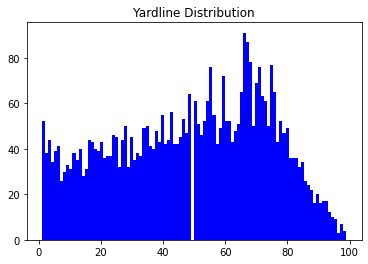

In [6]:
yardline = fourthdown['yardline_100']
print(yardline.shape)

plt.hist(yardline,color='blue', bins = 100)
plt.title('Yardline Distribution')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Play Types')]

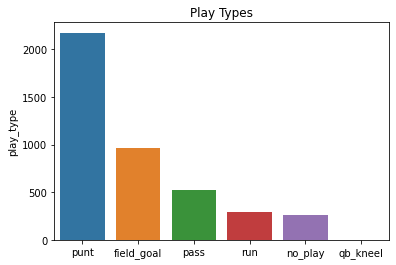

In [7]:
x = fourthdown.play_type.value_counts()
sns.barplot(x.index, x,).set(title="Play Types")



In [8]:
# result feature gives final score 
# negative score in favor of away team, positive score in favor of home team
# how do we classify a tie?

# won = fourthdown[(fourthdown['posteam_type'] == 'home' & fourthdown['result'] > 0) | (fourthdown['posteam_type'] == 'away' & fourthdown['result'] < 0)]
def who_won(row):
    row = row.to_numpy()
    if((row[0] == 'home' and row[1] > 0) or (row[0] == 'away' and row[1] < 0)):
        return 1
    elif(row[1] == 0): return 2 # use 2 for a tie
    else: return 0

labels = fourthdown[['posteam_type', 'result']].apply(who_won, axis=1)
fourthdown['labels'] = labels
print(fourthdown['labels'])

5        0
16       1
31       0
35       1
39       0
        ..
50497    0
50498    0
50507    1
50513    0
50526    1
Name: labels, Length: 4235, dtype: int64


/var/folders/bw/lg50kkvx081f41_6vrd9w_kh0000gn/T/ipykernel_1775/851947345.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourthdown['labels'] = labels


In [9]:
won = fourthdown[fourthdown['labels'] == 1]
lost = fourthdown[fourthdown['labels'] == 0]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Label Counts')]

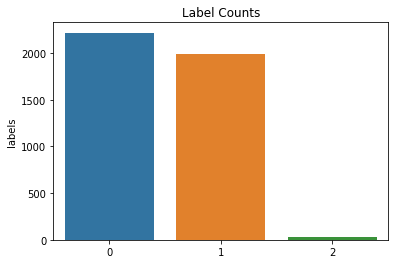

In [10]:
x = fourthdown.labels.value_counts()
sns.barplot(x.index, x,).set(title="Label Counts")

(-1.1098309613090545,
 1.1004681438464667,
 -1.1139321421635187,
 1.1083298430121105)

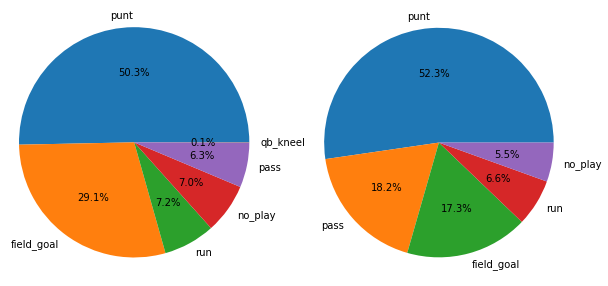

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

a = won.play_type.value_counts()
b = lost.play_type.value_counts()


ax1.pie(a,  labels=a.index,autopct='%1.1f%%')
ax1.axis('equal')

ax2.pie(b,  labels=b.index,autopct='%1.1f%%')
ax2.axis('equal')



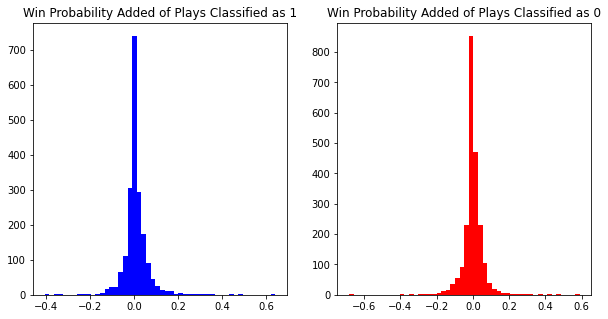

Teams that Won: 
Mean: 0.007708365481213988
Standard Deviation: 0.05828831294287519
Teams that Lost: 
Mean: 0.0007522205959276275
Standard Deviation: 0.05973854609515732


In [12]:
# plays that are not punts or field goals 


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
wpa = won['wpa']
wpa_mean, wpa_std = wpa.mean(), wpa.std()
ax1.hist(wpa,color='blue',bins=50)
ax1.set_title('Win Probability Added of Plays Classified as 1')

wpa_ = lost['wpa']
wpa__mean, wpa__std = wpa_.mean(), wpa_.std()
ax2.hist(wpa_, color='red',bins=50)
ax2.set_title('Win Probability Added of Plays Classified as 0')
plt.show()

print("Teams that Won: ")
print("Mean: " + str(wpa_mean))
print("Standard Deviation: " + str(wpa_std))

print("Teams that Lost: ")
print("Mean: " + str(wpa__mean))
print("Standard Deviation: " + str(wpa__std))



In [13]:
# wpa = win probability added
# The average wpa is just the (wpa + vegas_wpa) / 2
# The idea is to take the absolute value of the average wpa and have that be the weights
avg_wpa = fourthdown[['wpa', 'vegas_wpa']].apply(lambda x: (x[0] + x[1]) / 2, axis=1)
fourthdown['avg_wpa'] = avg_wpa


weights = fourthdown['avg_wpa'].apply(lambda x: abs(x))
fourthdown['weights'] = weights


print(fourthdown['avg_wpa'])
print("esketit")
print(fourthdown['weights'])

5        0.006982
16       0.024919
31       0.025890
35      -0.004165
39       0.059296
           ...   
50497   -0.031514
50498   -0.019756
50507    0.022418
50513    0.046366
50526    0.022052
Name: avg_wpa, Length: 4235, dtype: float64
esketit
5        0.006982
16       0.024919
31       0.025890
35       0.004165
39       0.059296
           ...   
50497    0.031514
50498    0.019756
50507    0.022418
50513    0.046366
50526    0.022052
Name: weights, Length: 4235, dtype: float64


/var/folders/bw/lg50kkvx081f41_6vrd9w_kh0000gn/T/ipykernel_1775/1161158257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourthdown['avg_wpa'] = avg_wpa
/var/folders/bw/lg50kkvx081f41_6vrd9w_kh0000gn/T/ipykernel_1775/1161158257.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourthdown['weights'] = weights


In [14]:
punt = fourthdown[fourthdown['play_type'] == 'punt']
run = fourthdown[fourthdown['play_type'] == 'run']
passing = fourthdown[fourthdown['play_type'] == 'pass']
field_goal = fourthdown[fourthdown['play_type'] == 'field_goal']

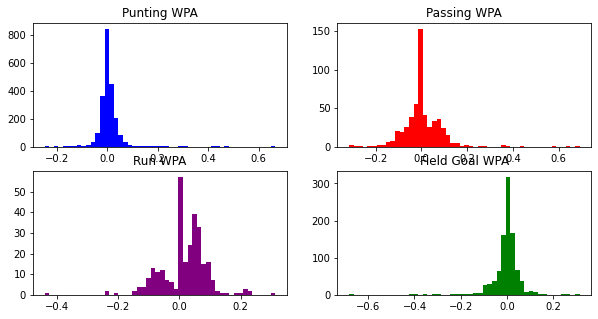

punt: mean: 0.005048776907073099 std: 0.043596927383369816
pass: mean: 0.006595747256606633 std: 0.09138724857629413
run: mean: 0.015928721504109653 std: 0.07852080425831681
fg: mean: -0.0013569526360666286 std: 0.06202120669717365


In [15]:
def showStats(dis, title):
    mean = dis.mean()
    std = dis.std()
    print(title +": mean: " + str(mean) + " std: " +str(std))



fig, axs = plt.subplots(2,2, figsize=(10,5))

punt_wpa = punt['avg_wpa']
axs[0,0].hist(punt_wpa,color='blue',bins=50)
axs[0,0].set_title('Punting WPA')

pass_wpa = passing['avg_wpa']
axs[0,1].hist(pass_wpa,color='red',bins=50)
axs[0,1].set_title('Passing WPA')

run_wpa = run['avg_wpa']
axs[1,0].hist(run_wpa,color='purple',bins=50)
axs[1,0].set_title('Run WPA')

fg_wpa = field_goal['avg_wpa']
axs[1,1].hist(fg_wpa,color='green',bins=50)
axs[1,1].set_title('Field Goal WPA')
plt.show()

showStats(punt_wpa, 'punt')
showStats(pass_wpa, 'pass')
showStats(run_wpa, 'run')
showStats(fg_wpa, 'fg')

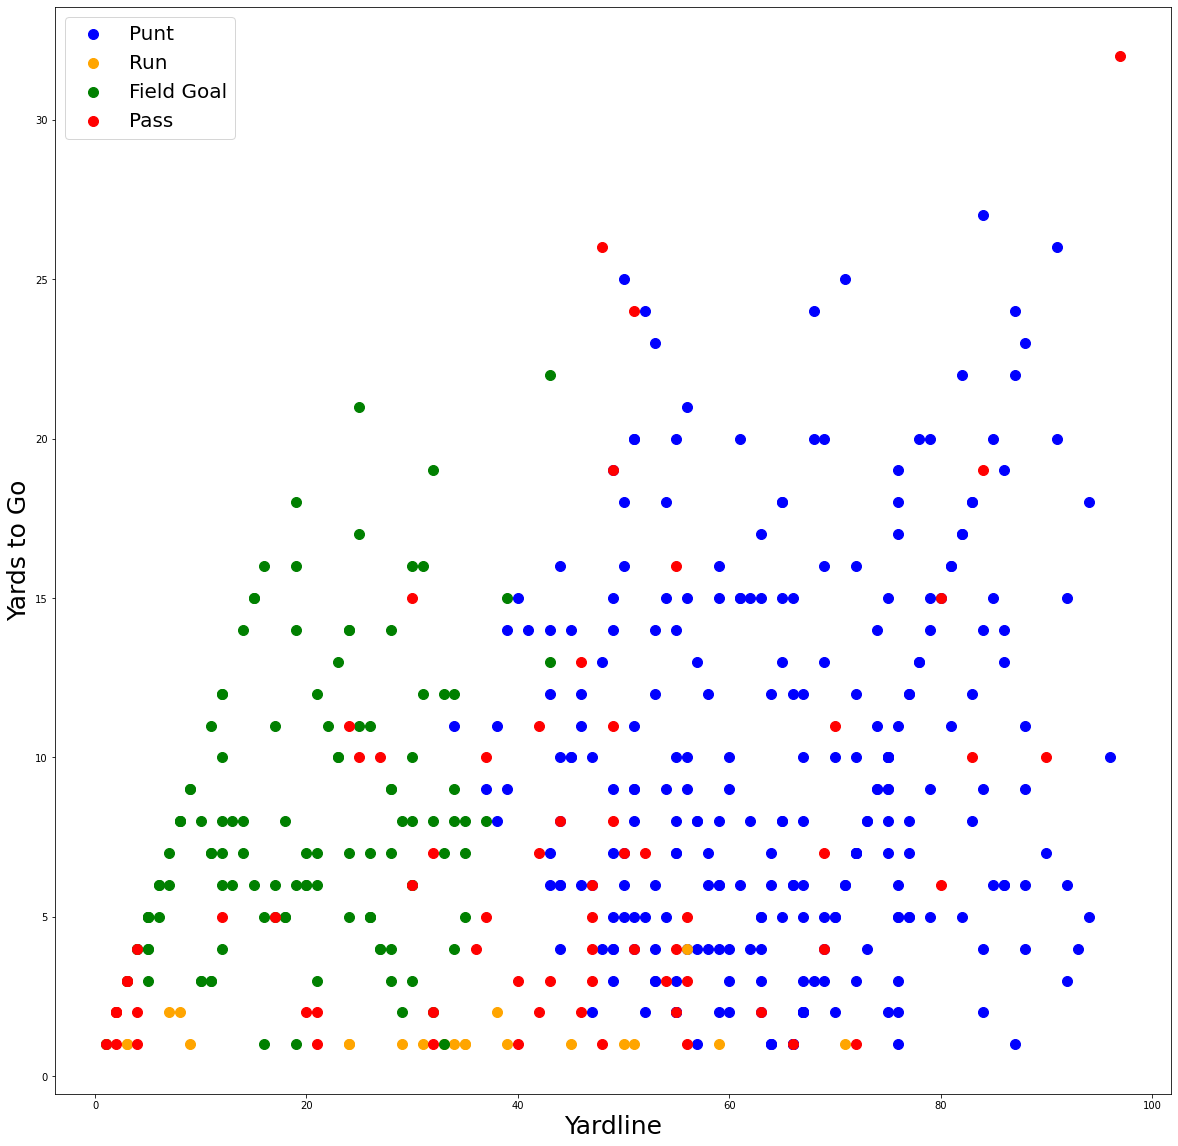

In [16]:
fig, axs = plt.subplots(1,1, figsize=(20,20))


sample = fourthdown.sample(500)

axs.scatter(x = sample[sample['play_type'] == 'punt']['yardline_100'], y = sample[sample['play_type'] == 'punt']['ydstogo'], s = 100,c='blue', label = 'Punt')
axs.scatter(x = sample[sample['play_type'] == 'run']['yardline_100'], y = sample[sample['play_type'] == 'run']['ydstogo'], s = 100,c='orange', label = 'Run')
axs.scatter(x = sample[sample['play_type'] == 'field_goal']['yardline_100'], y = sample[sample['play_type'] == 'field_goal']['ydstogo'], s = 100,c='green', label = 'Field Goal')
axs.scatter(x = sample[sample['play_type'] == 'pass']['yardline_100'], y = sample[sample['play_type'] == 'pass']['ydstogo'], s = 100,c='red', label = 'Pass')


axs.set_xlabel('Yardline', fontsize = 25)
axs.set_ylabel('Yards to Go', fontsize = 25)
axs.legend(prop={'size': 20})

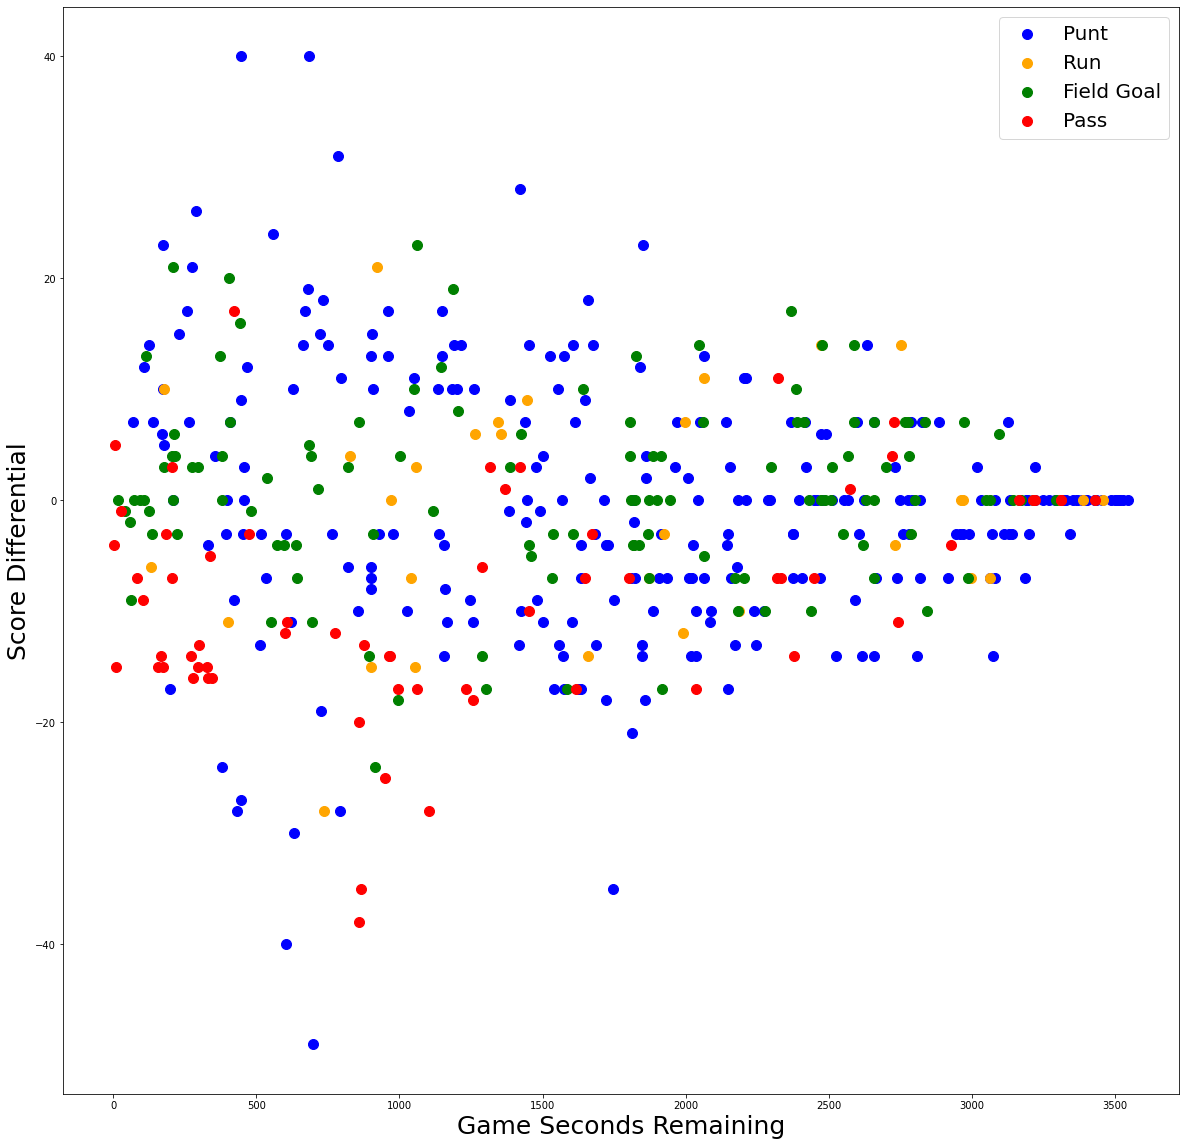

In [17]:
fig, axs = plt.subplots(1,1, figsize=(20,20))

sample = fourthdown.sample(500)

axs.scatter(x = sample[sample['play_type'] == 'punt']['game_seconds_remaining'], y = sample[sample['play_type'] == 'punt']['score_differential'], s = 100,c='blue', label = 'Punt')
axs.scatter(x = sample[sample['play_type'] == 'run']['game_seconds_remaining'], y = sample[sample['play_type'] == 'run']['score_differential'], s = 100,c='orange', label = 'Run')
axs.scatter(x = sample[sample['play_type'] == 'field_goal']['game_seconds_remaining'], y = sample[sample['play_type'] == 'field_goal']['score_differential'], s = 100,c='green', label = 'Field Goal')
axs.scatter(x = sample[sample['play_type'] == 'pass']['game_seconds_remaining'], y = sample[sample['play_type'] == 'pass']['score_differential'], s = 100,c='red', label = 'Pass')


axs.set_xlabel('Game Seconds Remaining', fontsize = 25)
axs.set_ylabel('Score Differential', fontsize = 25)
axs.legend(prop={'size': 20})

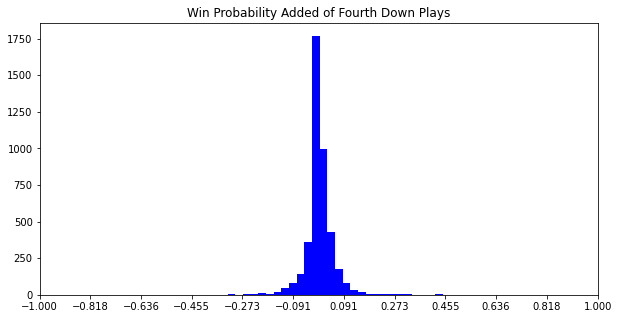

Quick Stats: 
Mean: 0.004495741365419995
Standard Deviation: 0.05860206221735856
Minimum: -0.6838559804395248
Maximum: 0.6920193582773209


In [18]:
# plays that are not punts or field goals 


fig, axs = plt.subplots(1,1, figsize=(10,5))
wpa = fourthdown['avg_wpa']
wpa_mean, wpa_std = wpa.mean(), wpa.std()
wpa_min, wpa_max = wpa.min(), wpa.max()
wpa_range = wpa_max - wpa_min
axs.hist(wpa,color='blue',bins=50)
axs.set_title('Win Probability Added of Fourth Down Plays')

x_ticks = np.linspace(-1,1,12)
axs.set_xticks(x_ticks)
plt.show()

print("Quick Stats: ")
print("Mean: " + str(wpa_mean))
print("Standard Deviation: " + str(wpa_std))
print("Minimum: " + str(wpa_min))
print("Maximum: " + str(wpa_max))




In [19]:
# brackets should be by standard deviation every 1/3 standard deviation
bracket = wpa_std
print(wpa.shape)
p = wpa[(wpa < 0.05) & (wpa > 0.025)]
print(p.shape)
print(bracket)
print(wpa_range / bracket)

# less than -0.2: 23


# greater than 0.2: 37
# .15 - .2: 24
# .1 - .15: 71 
# .75 - .1: 93 
# 0.05 - 0.075: 229
# 0.025 - 0.05



    

(4235,)
(488,)
0.05860206221735856
23.478275109391912


(array([  39.,   71.,   89.,  447., 1407., 1239.,  717.,   93.,   71.,
          62.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

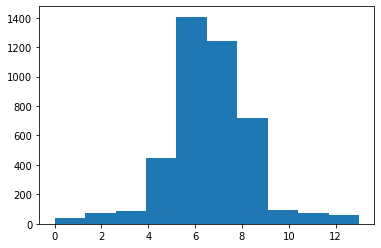

In [20]:

def discretizeData(data):
    discretizedData = np.empty(data.shape)
    for i,val in enumerate(data):
        if(val < -0.2):
            discretizedData[i] = 0
        elif(val >= -.2 and val < -.15):
            discretizedData[i]  = 1
        elif(val >= -.15 and val < -.1):
            discretizedData[i] = 2
        elif(val >= -.1 and val < -.075):
            discretizedData[i] = 3
        elif(val >= -.075 and val < -.05):
            discretizedData[i] = 4
        elif(val >= -.05 and val < -.025):
            discretizedData[i] = 5
        elif(val >= -.025 and val < 0):
            discretizedData[i] = 6
            
        elif(val >= 0 and val < 0.025):
            discretizedData[i] = 7
        elif(val >= 0.025 and val < 0.05):
            discretizedData[i] = 8
        elif(val >= 0.05 and val < 0.075):
            discretizedData[i] = 9
        elif(val >= 0.075 and val < 0.1):
            discretizedData[i] = 10
        elif(val >= 0.1 and val < 0.15):
            discretizedData[i] = 11 
        elif(val >= 0.15 and val < 0.2):
            discretizedData[i] = 12
        else: 
            discretizedData[i] = 13
    return discretizedData
data = wpa.to_numpy()
discretized_wpa = discretizeData(data)
plt.hist(discretized_wpa)



In [52]:
dataset = pd.read_csv('play_by_play_2021.csv')

important_titles = ["play_id",
                    "game_id", #Unique Game Id
                    "posteam", #Offence/Possetion Team
                    "result",
                    "posteam_type", #Offence Home/Away
                    "defteam", #Defence Team
                    "yardline_100", #Yards from Touchdown
                    "half_seconds_remaining",
                    "game_half",
                    "drive", #Number of Posetions
                    "down",
                    "goal_to_go", #is it 4th and goal? 0 if no, 1 if yes
                    "time",
                    "ydstogo", #yards till first down/touchdown
                    "desc", #description
                    "play_type",
                    "yards_gained", #0 if punted or field goal
                    "qb_kneel", #rare 4th down occurance but possible
                    "field_goal_result",
                    "kick_distance",
                    "posteam_timeouts_remaining",
                    "defteam_timeouts_remaining",
                    "total_home_score",
                    "total_away_score",
                    "posteam_score",
                    "defteam_score",
                    "score_differential",
                    "score_differential_post", #score differential after play happened
                    "no_score_prob",
                    "opp_fg_prob",
                    "opp_safety_prob",
                    "opp_td_prob",
                    "fg_prob",
                    "safety_prob",
                    "td_prob",
                    "wp", #winning percentage
                    "def_wp", 
                    "home_wp_post",
                    "away_wp_post",
                    "punt_blocked",
                    "third_down_converted",
                    "third_down_failed",
                    "fourth_down_converted",
                    "fourth_down_failed",
                    "punt_inside_twenty",
                    "punt_in_endzone",
                    "punt_out_of_bounds",
                    "punt_downed",
                    "punt_fair_catch",
                    "season", #2021 for now
                    "series_result",
                    "weather",
                    "nfl_api_id", #new data set-ish
                    "play_type_nfl",
                    "special_teams_play", #0 or 1
                    "drive_play_count",
                    "drive_time_of_possession",
                    "drive_first_downs",
                    "drive_inside20",
                    "drive_ended_with_score",
                    "roof",
                    "surface",
                    "wind" #no valuable info could add from weather
                   ]

baseline_titles = [
    "yardline_100",
    "game_seconds_remaining",
    "down",
    "ydstogo",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "wp",
    "def_wp",
    "no_score_prob",
    "opp_fg_prob",
    "opp_safety_prob",
    "opp_td_prob",
    "fg_prob",
    "safety_prob",
    "td_prob",
    
    
    
    
]

dataset = dataset[dataset['down']==4][baseline_titles]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [53]:
X = dataset.to_numpy()
y = discretized_wpa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
# Baseline Classifier for guessing the win probability added of a 4th down play
# Keep in mind: random guess: 1/14 = 0.07142857142

from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2)
clf = clf.fit(X_train, y_train)

print("Training Score: " + str(clf.score(X_train, y_train)))
print("Testing Score: " + str(clf.score(X_test, y_test)))


Training Score: 0.5808736717827627
Testing Score: 0.36363636363636365


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)

print("Training Score: " + str(clf.score(X_train, y_train)))
print("Testing Score: " + str(clf.score(X_test, y_test)))

Training Score: 0.987012987012987
Testing Score: 0.4179456906729634


In [64]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='sgd',alpha=.001,hidden_layer_sizes=(12,8), random_state=1, learning_rate='adaptive')
clf = clf.fit(X_train, y_train)
print("Training Score: " + str(clf.score(X_train, y_train)))
print("Testing Score: " + str(clf.score(X_test, y_test)))

Training Score: 0.3412042502951594
Testing Score: 0.29279811097992914


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [67]:
from sklearn.model_selection import RandomizedSearchCV

param_space = {"bootstrap": [True],
        "max_depth": [6, 8, 10, 12, 14],
        "max_features": ['auto', 'sqrt','log2'],
        "min_samples_leaf": [2, 3, 4],
        "min_samples_split": [2, 3, 4, 5],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

forest_clf = RandomForestClassifier()
forest_grid_search = RandomizedSearchCV(forest_clf, param_space, n_iter=32,
                                        scoring="accuracy", verbose=True, cv=5,
                                        n_jobs=-1, random_state=42)

forest_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=32,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [6, 8, 10, 12, 14],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='accuracy', verbose=True)

In [68]:
forest_grid_search.best_params_

{'n_estimators': 400,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': True}

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=400,min_samples_split=3,min_samples_leaf=3,max_features='sqrt',max_depth=12,bootstrap=True)
clf = clf.fit(X_train, y_train)

print("Training Score: " + str(clf.score(X_train, y_train)))
print("Testing Score: " + str(clf.score(X_test, y_test)))

Training Score: 0.7981109799291618
Testing Score: 0.42266824085005905


In [96]:
import tensorflow as tf
from scipy.stats import reciprocal

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[16]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(15, activation="softmax"))
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

keras_param_space = {"n_hidden": [1, 2, 3, 4],
                      "n_neurons": np.arange(30, 300),
                      "learning_rate": reciprocal(3e-4, 3e-2) 
}

keras_rand_search = RandomizedSearchCV(keras_clf, keras_param_space, n_iter=20, 
                                   cv=5, scoring="accuracy", n_jobs=-1, verbose=False)

keras_rand_search.fit(X_train, y_train, epochs=100,
                       validation_data=(X_test, y_test),
                       callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/var/folders/bw/lg50kkvx081f41_6vrd9w_kh0000gn/T/ipykernel_1775/978321459.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


85/85 [==============================] - 2s 12ms/step - loss: 7419622588416.0000 - accuracy: 0.2708 - val_loss: 2.7651 - val_accuracy: 0.3152
Epoch 2/100
85/85 [==============================] - 2s 11ms/step - loss: 19825234962151284567465315532800.0000 - accuracy: 0.2700 - val_loss: 2.6677 - val_accuracy: 0.2940
Epoch 2/100
85/85 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.1210 - val_loss: nan - val_accuracy: 0.0059
Epoch 2/100
85/85 [==============================] - 2s 11ms/step - loss: nan - accuracy: 0.0771 - val_loss: nan - val_accuracy: 0.0059
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 3888.6711 - accuracy: 0.3373 - val_loss: 2.5712 - val_accuracy: 0.2928
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 2.6047 - accuracy: 0.3207 - val_loss: 2.6842 - val_accuracy: 0.2940
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 76359099135619808362496.0000 - accuracy: 0.3416 - val_l

85/85 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.0044 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
85/85 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
85/85 [==============================] - 1s 6ms/step - loss: 2.1603 - accuracy: 0.2978 - val_loss: 2.1633 - val_accuracy: 0.3152
Epoch 12/100
85/85 [==============================] - 1s 6ms/step - loss: 2.1273 - accuracy: 0.3428 - val_loss: 2.2574 - val_accuracy: 0.2940
Epoch 12/100
85/85 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
85/85 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.0055 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
85/85 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
85/85 [=============================

85/85 [==============================] - 0s 3ms/step - loss: 2.0974 - accuracy: 0.3384 - val_loss: 2.1097 - val_accuracy: 0.2940
Epoch 14/100
85/85 [==============================] - 0s 4ms/step - loss: 2.0791 - accuracy: 0.3428 - val_loss: 2.2150 - val_accuracy: 0.2940
Epoch 14/100
85/85 [==============================] - 0s 3ms/step - loss: 2.0720 - accuracy: 0.3384 - val_loss: 2.0885 - val_accuracy: 0.2940
Epoch 15/100
85/85 [==============================] - 0s 3ms/step - loss: 2.0596 - accuracy: 0.3428 - val_loss: 2.1978 - val_accuracy: 0.2940
Epoch 15/100
27/85 [========>.....................] - ETA: 0s - loss: 2.0436 - accuracy: 0.3472Epoch 1/100
Epoch 1/100
Epoch 1/100
53/85 [=================>............] - ETA: 0s - loss: 2.0518 - accuracy: 0.3514Epoch 1/100
Epoch 1/100
85/85 [==============================] - 0s 3ms/step - loss: 2.0503 - accuracy: 0.3384 - val_loss: 2.0714 - val_accuracy: 0.2940
Epoch 16/100
85/85 [==============================] - 0s 3ms/step - loss: 2.042

85/85 [==============================] - 0s 5ms/step - loss: 2.2113 - accuracy: 0.3384 - val_loss: 2.2114 - val_accuracy: 0.2904
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 2.2337 - accuracy: 0.3410 - val_loss: 2.2147 - val_accuracy: 0.2928
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 2.2226 - accuracy: 0.3397 - val_loss: 2.2164 - val_accuracy: 0.2952
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 2.2065 - accuracy: 0.3465 - val_loss: 2.2142 - val_accuracy: 0.2916
Epoch 6/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 6/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0055 - val_loss: nan - val_accuracy: 0.0059
Epoch 5/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9535 - accuracy: 0.3384 - val_loss: 1.9897 - val_accuracy: 0.2940
Epoch 24/100
85/85 [=================

85/85 [==============================] - 0s 5ms/step - loss: 1.9857 - accuracy: 0.3417 - val_loss: 2.0117 - val_accuracy: 0.2940
Epoch 13/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9834 - accuracy: 0.3416 - val_loss: 2.0174 - val_accuracy: 0.2928
Epoch 13/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9641 - accuracy: 0.3476 - val_loss: 2.0174 - val_accuracy: 0.2916
Epoch 13/100
85/85 [==============================] - 2s 13ms/step - loss: 3399.2432 - accuracy: 0.3117 - val_loss: 2.5745 - val_accuracy: 0.2904
Epoch 2/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9203 - accuracy: 0.3384 - val_loss: 1.9621 - val_accuracy: 0.2940
Epoch 31/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9570 - accuracy: 0.3376 - val_loss: 2.0049 - val_accuracy: 0.2916
Epoch 14/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9320 - accuracy: 0.3428 - val_loss: 2.0820 - val_accuracy: 0.2940
Epoch 31/100
85/

85/85 [==============================] - 0s 5ms/step - loss: 1.9050 - accuracy: 0.3369 - val_loss: 1.9589 - val_accuracy: 0.2916
Epoch 21/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9196 - accuracy: 0.3424 - val_loss: 1.9537 - val_accuracy: 0.2940
Epoch 21/100
85/85 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0332 - val_loss: nan - val_accuracy: 0.0059
Epoch 2/100
Epoch 21/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9138 - accuracy: 0.3428 - val_loss: 2.0644 - val_accuracy: 0.2940
Epoch 38/100
85/85 [==============================] - 0s 4ms/step - loss: 2.0474 - accuracy: 0.3397 - val_loss: 2.0692 - val_accuracy: 0.2916
Epoch 10/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9003 - accuracy: 0.3384 - val_loss: 1.9558 - val_accuracy: 0.2940
Epoch 22/100
85/85 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0480 - val_loss: nan - val_accuracy: 0.0059
Epoch 2/100
85/85

85/85 [==============================] - 0s 5ms/step - loss: 1.9596 - accuracy: 0.3405 - val_loss: 1.9948 - val_accuracy: 0.2916
Epoch 15/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8834 - accuracy: 0.3402 - val_loss: 1.9399 - val_accuracy: 0.2916
Epoch 27/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8984 - accuracy: 0.3424 - val_loss: 1.9341 - val_accuracy: 0.2952
Epoch 27/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8921 - accuracy: 0.3384 - val_loss: 1.9352 - val_accuracy: 0.2940
Epoch 44/100
85/85 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 7/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8954 - accuracy: 0.3401 - val_loss: 1.9421 - val_accuracy: 0.2916
Epoch 27/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9033 - accuracy: 0.3428 - val_loss: 2.0540 - val_accuracy: 0.2940
Epoch 44/100
85/85 [======

2022-04-30 12:28:05.211498: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


85/85 [==============================] - 0s 4ms/step - loss: 1.8647 - accuracy: 0.3491 - val_loss: 1.9291 - val_accuracy: 0.2916
Epoch 33/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9135 - accuracy: 0.3405 - val_loss: 1.9551 - val_accuracy: 0.2893
Epoch 22/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8688 - accuracy: 0.3380 - val_loss: 1.9262 - val_accuracy: 0.2940
Epoch 34/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8839 - accuracy: 0.3432 - val_loss: 1.9212 - val_accuracy: 0.2940
Epoch 34/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8805 - accuracy: 0.3408 - val_loss: 1.9285 - val_accuracy: 0.2916
Epoch 34/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8945 - accuracy: 0.3428 - val_loss: 2.0454 - val_accuracy: 0.2940
Epoch 51/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8631 - accuracy: 0.3480 - val_loss: 1.9282 - val_accuracy: 0.2904
Epoch 34/100
37/85 

2022-04-30 12:28:05.567675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


85/85 [==============================] - 0s 4ms/step - loss: 1.9095 - accuracy: 0.3408 - val_loss: 1.9512 - val_accuracy: 0.2893
Epoch 23/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8676 - accuracy: 0.3391 - val_loss: 1.9271 - val_accuracy: 0.2928
Epoch 35/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8823 - accuracy: 0.3435 - val_loss: 1.9195 - val_accuracy: 0.2940
Epoch 35/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8787 - accuracy: 0.3408 - val_loss: 1.9268 - val_accuracy: 0.2904
Epoch 35/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8935 - accuracy: 0.3428 - val_loss: 2.0444 - val_accuracy: 0.2940
Epoch 52/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8616 - accuracy: 0.3476 - val_loss: 1.9277 - val_accuracy: 0.2904
Epoch 35/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9056 - accuracy: 0.3412 - val_loss: 1.9482 - val_accuracy: 0.2893
Epoch 24/100
85/85 

85/85 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 7/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8745 - accuracy: 0.3432 - val_loss: 1.9127 - val_accuracy: 0.2940
Epoch 41/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8601 - accuracy: 0.3369 - val_loss: 1.9196 - val_accuracy: 0.2928
Epoch 41/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8710 - accuracy: 0.3412 - val_loss: 1.9209 - val_accuracy: 0.2881
Epoch 41/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0055 - val_loss: nan - val_accuracy: 0.0059
Epoch 4/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8542 - accuracy: 0.3483 - val_loss: 1.9217 - val_accuracy: 0.2904
Epoch 41/100
Epoch 58/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 3/100
85/85 [=======

85/85 [==============================] - 0s 6ms/step - loss: 1.8844 - accuracy: 0.3428 - val_loss: 2.0354 - val_accuracy: 0.2940
Epoch 46/100
Epoch 63/100
85/85 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.0044 - val_loss: nan - val_accuracy: 0.0059
Epoch 5/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8535 - accuracy: 0.3373 - val_loss: 1.9124 - val_accuracy: 0.2916
Epoch 47/100
85/85 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 4/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8643 - accuracy: 0.3423 - val_loss: 1.9180 - val_accuracy: 0.2904
Epoch 47/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8691 - accuracy: 0.3432 - val_loss: 1.9082 - val_accuracy: 0.2940
Epoch 47/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8484 - accuracy: 0.3480 - val_loss: 1.9170 - val_accuracy: 0.2904
Epoch 47/100
85/85 [

85/85 [==============================] - 0s 6ms/step - loss: 1.8530 - accuracy: 0.3387 - val_loss: 1.9110 - val_accuracy: 0.2916
Epoch 48/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8685 - accuracy: 0.3432 - val_loss: 1.9077 - val_accuracy: 0.2940
Epoch 48/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8831 - accuracy: 0.3428 - val_loss: 2.0341 - val_accuracy: 0.2940
Epoch 65/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8478 - accuracy: 0.3487 - val_loss: 1.9164 - val_accuracy: 0.2904
Epoch 48/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8726 - accuracy: 0.3384 - val_loss: 1.9162 - val_accuracy: 0.2940
Epoch 65/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8770 - accuracy: 0.3401 - val_loss: 1.9245 - val_accuracy: 0.2881
Epoch 37/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100


85/85 [==============================] - 0s 5ms/step - loss: 1.8660 - accuracy: 0.3369 - val_loss: 1.9110 - val_accuracy: 0.2916
Epoch 49/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8620 - accuracy: 0.3423 - val_loss: 1.9149 - val_accuracy: 0.2916
Epoch 49/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0044 - val_loss: nan - val_accuracy: 0.0059
Epoch 7/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8679 - accuracy: 0.3421 - val_loss: 1.9070 - val_accuracy: 0.2940
Epoch 49/100
85/85 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8469 - accuracy: 0.3491 - val_loss: 1.9164 - val_accuracy: 0.2904
Epoch 49/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8825 - accuracy: 0.3428 - val_loss: 2.0335 - val_accuracy: 0.2940
Epoch 66/100
85/85 [=============

85/85 [==============================] - 0s 4ms/step - loss: 1.8746 - accuracy: 0.3416 - val_loss: 1.9227 - val_accuracy: 0.2881
Epoch 39/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8605 - accuracy: 0.3419 - val_loss: 1.9138 - val_accuracy: 0.2916
Epoch 51/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8665 - accuracy: 0.3428 - val_loss: 1.9060 - val_accuracy: 0.2940
Epoch 51/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8454 - accuracy: 0.3494 - val_loss: 1.9144 - val_accuracy: 0.2916
Epoch 51/100
Epoch 1/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8814 - accuracy: 0.3428 - val_loss: 2.0324 - val_accuracy: 0.2940
Epoch 68/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0044 - val_loss: nan - val_accuracy: 0.0059
Epoch 9/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8709 - accuracy: 0.3384 - val_loss: 1.9138 - val_accuracy: 0.2940
Epoch 68/100
8

85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 9/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8515 - accuracy: 0.3376 - val_loss: 1.9091 - val_accuracy: 0.2916
Epoch 53/100
85/85 [==============================] - 2s 11ms/step - loss: 1732.3926 - accuracy: 0.3221 - val_loss: 2.4385 - val_accuracy: 0.2940
Epoch 2/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8592 - accuracy: 0.3394 - val_loss: 1.9099 - val_accuracy: 0.2916
Epoch 53/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8443 - accuracy: 0.3483 - val_loss: 1.9131 - val_accuracy: 0.2904
Epoch 53/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8652 - accuracy: 0.3428 - val_loss: 1.9053 - val_accuracy: 0.2928
Epoch 53/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8804 - accuracy: 0.3428 - val_loss: 2.0313 - val_accuracy: 0.2940
Epoch 70/100
85/85 [===

85/85 [==============================] - 0s 5ms/step - loss: 1.8508 - accuracy: 0.3362 - val_loss: 1.9078 - val_accuracy: 0.2916
Epoch 54/100
85/85 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
85/85 [==============================] - 0s 5ms/step - loss: 2.3379 - accuracy: 0.3358 - val_loss: 2.2536 - val_accuracy: 0.2928
Epoch 3/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8581 - accuracy: 0.3423 - val_loss: 1.9135 - val_accuracy: 0.2904
Epoch 54/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8435 - accuracy: 0.3487 - val_loss: 1.9134 - val_accuracy: 0.2904
Epoch 54/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8799 - accuracy: 0.3428 - val_loss: 2.0308 - val_accuracy: 0.2940
Epoch 71/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8694 - accuracy: 0.3384 - val_loss: 1.9121 - val_accuracy: 0.2940
Epoch 71/100
85/85 [======

85/85 [==============================] - 0s 4ms/step - loss: 2.0764 - accuracy: 0.3417 - val_loss: 2.0772 - val_accuracy: 0.2904
Epoch 5/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8555 - accuracy: 0.3408 - val_loss: 1.9119 - val_accuracy: 0.2904
Epoch 60/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8400 - accuracy: 0.3487 - val_loss: 1.9109 - val_accuracy: 0.2893
Epoch 60/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8772 - accuracy: 0.3428 - val_loss: 2.0281 - val_accuracy: 0.2940
Epoch 77/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8669 - accuracy: 0.3384 - val_loss: 1.9100 - val_accuracy: 0.2940
Epoch 77/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8644 - accuracy: 0.3408 - val_loss: 1.9142 - val_accuracy: 0.2916
Epoch 49/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8469 - accuracy: 0.3373 - val_loss: 1.9047 - val_accuracy: 0.2928
Epoch 61/100
85/85 [

85/85 [==============================] - 0s 4ms/step - loss: 1.8764 - accuracy: 0.3428 - val_loss: 2.0274 - val_accuracy: 0.2940
Epoch 79/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8629 - accuracy: 0.3416 - val_loss: 1.9145 - val_accuracy: 0.2904
Epoch 51/100
Epoch 63/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9280 - accuracy: 0.3362 - val_loss: 1.9450 - val_accuracy: 0.2904
Epoch 12/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9606 - accuracy: 0.3480 - val_loss: 2.0012 - val_accuracy: 0.2893
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8529 - accuracy: 0.3423 - val_loss: 1.9119 - val_accuracy: 0.2916
Epoch 63/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8599 - accuracy: 0.3424 - val_loss: 1.9016 - val_accuracy: 0.2928
Epoch 63/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8388 - accuracy: 0.3480 - val_loss: 1.9078 - val_accuracy: 0.2916
Epoch 6

Epoch 13/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8691 - accuracy: 0.3373 - val_loss: 1.9215 - val_accuracy: 0.2904
Epoch 18/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8575 - accuracy: 0.3424 - val_loss: 1.8999 - val_accuracy: 0.2916
Epoch 69/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8499 - accuracy: 0.3397 - val_loss: 1.9064 - val_accuracy: 0.2928
Epoch 69/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9342 - accuracy: 0.3408 - val_loss: 1.9656 - val_accuracy: 0.2940
Epoch 9/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9532 - accuracy: 0.3416 - val_loss: 1.9818 - val_accuracy: 0.2928
Epoch 8/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8423 - accuracy: 0.3376 - val_loss: 1.9032 - val_accuracy: 0.2893
Epoch 58/100
Epoch 70/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8739 - accuracy: 0.3428 - val_loss: 2.0250 - val_accuracy: 0.

85/85 [==============================] - 0s 4ms/step - loss: 1.9375 - accuracy: 0.3383 - val_loss: 1.9677 - val_accuracy: 0.2881
Epoch 9/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8350 - accuracy: 0.3483 - val_loss: 1.9034 - val_accuracy: 0.2928
Epoch 70/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8422 - accuracy: 0.3384 - val_loss: 1.9012 - val_accuracy: 0.2928
Epoch 71/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8736 - accuracy: 0.3428 - val_loss: 2.0248 - val_accuracy: 0.2940
Epoch 87/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8580 - accuracy: 0.3408 - val_loss: 1.9101 - val_accuracy: 0.2893
Epoch 59/100
Epoch 87/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8686 - accuracy: 0.3483 - val_loss: 1.9293 - val_accuracy: 0.2893
Epoch 15/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8642 - accuracy: 0.3376 - val_loss: 1.9165 - val_accuracy: 0.2940
Epoch 2

85/85 [==============================] - 0s 5ms/step - loss: 1.8476 - accuracy: 0.3419 - val_loss: 1.9051 - val_accuracy: 0.2928
Epoch 75/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8546 - accuracy: 0.3450 - val_loss: 1.8959 - val_accuracy: 0.2928
Epoch 75/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8936 - accuracy: 0.3401 - val_loss: 1.9271 - val_accuracy: 0.2904
Epoch 14/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8315 - accuracy: 0.3476 - val_loss: 1.8995 - val_accuracy: 0.2881
Epoch 75/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8418 - accuracy: 0.3387 - val_loss: 1.9014 - val_accuracy: 0.2904
Epoch 76/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8722 - accuracy: 0.3428 - val_loss: 2.0233 - val_accuracy: 0.2940
Epoch 92/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8514 - accuracy: 0.3498 - val_loss: 1.9130 - val_accuracy: 0.2904
Epoch 20/100
85/85 

85/85 [==============================] - 0s 5ms/step - loss: 1.8468 - accuracy: 0.3423 - val_loss: 1.9054 - val_accuracy: 0.2940
Epoch 76/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8891 - accuracy: 0.3405 - val_loss: 1.9258 - val_accuracy: 0.2893
Epoch 15/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8556 - accuracy: 0.3419 - val_loss: 1.9091 - val_accuracy: 0.2916
Epoch 65/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8608 - accuracy: 0.3491 - val_loss: 1.9012 - val_accuracy: 0.2904
Epoch 76/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8410 - accuracy: 0.3376 - val_loss: 1.9012 - val_accuracy: 0.2904
Epoch 77/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8616 - accuracy: 0.3384 - val_loss: 1.9046 - val_accuracy: 0.2940
Epoch 93/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9060 - accuracy: 0.3397 - val_loss: 1.9205 - val_accuracy: 0.2928
Epoch 22/100
Epoch 

85/85 [==============================] - 0s 5ms/step - loss: 1.8613 - accuracy: 0.3384 - val_loss: 1.9039 - val_accuracy: 0.2940
Epoch 94/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8674 - accuracy: 0.3435 - val_loss: 1.9084 - val_accuracy: 0.2928
Epoch 23/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8766 - accuracy: 0.3419 - val_loss: 1.9165 - val_accuracy: 0.2928
Epoch 18/100
32/85 [==========>...................] - ETA: 0s - loss: 1.8836 - accuracy: 0.3330Epoch 27/100
Epoch 78/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8490 - accuracy: 0.3491 - val_loss: 1.9148 - val_accuracy: 0.2881
Epoch 22/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8554 - accuracy: 0.3428 - val_loss: 1.8991 - val_accuracy: 0.2893
Epoch 78/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8332 - accuracy: 0.3483 - val_loss: 1.9019 - val_accuracy: 0.2893
Epoch 78/100
85/85 [==============================] -

Epoch 82/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8445 - accuracy: 0.3416 - val_loss: 1.9039 - val_accuracy: 0.2940
Epoch 82/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8316 - accuracy: 0.3480 - val_loss: 1.9019 - val_accuracy: 0.2904
Epoch 82/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8533 - accuracy: 0.3423 - val_loss: 1.9068 - val_accuracy: 0.2904
Epoch 71/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8393 - accuracy: 0.3387 - val_loss: 1.8987 - val_accuracy: 0.2904
Epoch 83/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8657 - accuracy: 0.3423 - val_loss: 1.9076 - val_accuracy: 0.2928
Epoch 23/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8401 - accuracy: 0.3469 - val_loss: 1.9092 - val_accuracy: 0.2893
Epoch 27/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8705 - accuracy: 0.3428 - val_loss: 2.0217 - val_accuracy: 0.2940
Epoch 

Epoch 29/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8354 - accuracy: 0.3491 - val_loss: 1.9052 - val_accuracy: 0.2893
Epoch 33/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8580 - accuracy: 0.3428 - val_loss: 1.9004 - val_accuracy: 0.2904
Epoch 34/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8412 - accuracy: 0.3380 - val_loss: 1.8976 - val_accuracy: 0.2869
Epoch 38/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8608 - accuracy: 0.3423 - val_loss: 1.9053 - val_accuracy: 0.2893
Epoch 28/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8419 - accuracy: 0.3430 - val_loss: 1.9007 - val_accuracy: 0.2952
Epoch 89/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8511 - accuracy: 0.3419 - val_loss: 1.9056 - val_accuracy: 0.2916
Epoch 78/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8366 - accuracy: 0.3376 - val_loss: 1.8983 - val_accuracy: 0.2916
Epoch 

85/85 [==============================] - 0s 4ms/step - loss: 1.8415 - accuracy: 0.3380 - val_loss: 1.9026 - val_accuracy: 0.2881
Epoch 40/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8596 - accuracy: 0.3419 - val_loss: 1.9031 - val_accuracy: 0.2904
Epoch 30/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8414 - accuracy: 0.3419 - val_loss: 1.9036 - val_accuracy: 0.2916
Epoch 91/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8504 - accuracy: 0.3430 - val_loss: 1.9062 - val_accuracy: 0.2916
Epoch 92/100
Epoch 80/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8327 - accuracy: 0.3506 - val_loss: 1.9074 - val_accuracy: 0.2916
Epoch 36/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8877 - accuracy: 0.3369 - val_loss: 1.9017 - val_accuracy: 0.2893
Epoch 41/100


85/85 [==============================] - 1s 6ms/step - loss: 1.8569 - accuracy: 0.3405 - val_loss: 1.9047 - val_accuracy: 0.2904
Epoch 31/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8504 - accuracy: 0.3427 - val_loss: 1.9060 - val_accuracy: 0.2916
Epoch 81/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8379 - accuracy: 0.3369 - val_loss: 1.8974 - val_accuracy: 0.2904
Epoch 93/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8538 - accuracy: 0.3423 - val_loss: 1.9036 - val_accuracy: 0.2928
Epoch 33/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8708 - accuracy: 0.3494 - val_loss: 1.9042 - val_accuracy: 0.2869
Epoch 37/100
85/85 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0428 - val_loss: nan - val_accuracy: 0.0059
Epoch 42/100
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8565 - accuracy: 0.3416 - val_loss: 1.8972 - val_accuracy: 0.2916
Epoch 32/100

85/85 [==============================] - 1s 6ms/step - loss: 2.5209 - accuracy: 0.3417 - val_loss: 2.5116 - val_accuracy: 0.2916
Epoch 6/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9241 - accuracy: 0.3450 - val_loss: 1.8971 - val_accuracy: 0.2928
Epoch 43/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8309 - accuracy: 0.3476 - val_loss: 1.9005 - val_accuracy: 0.2904
Epoch 42/100
85/85 [==============================] - 1s 6ms/step - loss: 2.5141 - accuracy: 0.3419 - val_loss: 2.4990 - val_accuracy: 0.2940
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8518 - accuracy: 0.3423 - val_loss: 1.8955 - val_accuracy: 0.2904
Epoch 37/100
85/85 [==============================] - 1s 6ms/step - loss: 2.5173 - accuracy: 0.3428 - val_loss: 2.5012 - val_accuracy: 0.2940
Epoch 6/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8372 - accuracy: 0.3376 - val_loss: 1.8969 - val_accuracy: 0.2869
Epoch 47/100
85/85 [==

85/85 [==============================] - 0s 6ms/step - loss: 1.8515 - accuracy: 0.3432 - val_loss: 1.8963 - val_accuracy: 0.2928
Epoch 46/100
Epoch 47/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8489 - accuracy: 0.3412 - val_loss: 1.8966 - val_accuracy: 0.2904
Epoch 41/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8400 - accuracy: 0.3384 - val_loss: 1.8999 - val_accuracy: 0.2916
Epoch 51/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8470 - accuracy: 0.3427 - val_loss: 1.9060 - val_accuracy: 0.2904
Epoch 91/100
85/85 [==============================] - 1s 6ms/step - loss: 2.3369 - accuracy: 0.3369 - val_loss: 2.3441 - val_accuracy: 0.2952
Epoch 10/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8484 - accuracy: 0.3412 - val_loss: 1.8986 - val_accuracy: 0.2904
Epoch 43/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8272 - accuracy: 0.3483 - val_loss: 1.8954 - val_accuracy: 0.2893
Epoch 

85/85 [==============================] - 0s 5ms/step - loss: 1.8389 - accuracy: 0.3391 - val_loss: 1.8972 - val_accuracy: 0.2916
Epoch 52/100
85/85 [==============================] - 0s 5ms/step - loss: 2.2890 - accuracy: 0.3416 - val_loss: 2.2955 - val_accuracy: 0.2940
Epoch 11/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8468 - accuracy: 0.3423 - val_loss: 1.9059 - val_accuracy: 0.2904
Epoch 92/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8478 - accuracy: 0.3405 - val_loss: 1.8991 - val_accuracy: 0.2904
Epoch 44/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8504 - accuracy: 0.3428 - val_loss: 1.8960 - val_accuracy: 0.2928
Epoch 49/100
85/85 [==============================] - 0s 5ms/step - loss: 2.2732 - accuracy: 0.3491 - val_loss: 2.2884 - val_accuracy: 0.2940
Epoch 12/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8390 - accuracy: 0.3380 - val_loss: 1.8992 - val_accuracy: 0.2881
Epoch 53/100
85/85 

85/85 [==============================] - 0s 6ms/step - loss: 1.8276 - accuracy: 0.3480 - val_loss: 1.8961 - val_accuracy: 0.2904
Epoch 54/100
85/85 [==============================] - 0s 5ms/step - loss: 2.6931 - accuracy: 0.3229 - val_loss: 2.6985 - val_accuracy: 0.2798
Epoch 4/100
85/85 [==============================] - 0s 6ms/step - loss: 2.6671 - accuracy: 0.3309 - val_loss: 2.6408 - val_accuracy: 0.2845
Epoch 4/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8465 - accuracy: 0.3423 - val_loss: 1.9026 - val_accuracy: 0.2916
Epoch 99/100
85/85 [==============================] - 0s 5ms/step - loss: 2.0806 - accuracy: 0.3506 - val_loss: 2.1189 - val_accuracy: 0.2940
Epoch 18/100
85/85 [==============================] - 2s 13ms/step - loss: 26.7416 - accuracy: 0.2834 - val_loss: 2.7426 - val_accuracy: 0.2562
Epoch 2/100
85/85 [==============================] - 0s 6ms/step - loss: 2.0426 - accuracy: 0.3419 - val_loss: 2.0743 - val_accuracy: 0.2940
Epoch 18/100
85/85 [

85/85 [==============================] - 0s 6ms/step - loss: 1.9655 - accuracy: 0.3424 - val_loss: 1.9996 - val_accuracy: 0.2904
Epoch 23/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9691 - accuracy: 0.3491 - val_loss: 2.0230 - val_accuracy: 0.2940
Epoch 24/100
85/85 [==============================] - 0s 6ms/step - loss: 2.4051 - accuracy: 0.3353 - val_loss: 2.4097 - val_accuracy: 0.2893
Epoch 10/100
85/85 [==============================] - 0s 6ms/step - loss: 2.7401 - accuracy: 0.3077 - val_loss: 2.6801 - val_accuracy: 0.2704
Epoch 8/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9381 - accuracy: 0.3423 - val_loss: 1.9782 - val_accuracy: 0.2940
Epoch 24/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8243 - accuracy: 0.3494 - val_loss: 1.8915 - val_accuracy: 0.2881
Epoch 61/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8453 - accuracy: 0.3421 - val_loss: 1.8931 - val_accuracy: 0.2928
Epoch 62/100
85/85 [

85/85 [==============================] - 0s 6ms/step - loss: 1.9278 - accuracy: 0.3419 - val_loss: 1.9694 - val_accuracy: 0.2940
Epoch 25/100
85/85 [==============================] - 0s 5ms/step - loss: 2.6711 - accuracy: 0.3170 - val_loss: 2.6463 - val_accuracy: 0.2786
Epoch 12/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8457 - accuracy: 0.3424 - val_loss: 1.8924 - val_accuracy: 0.2928
Epoch 63/100
85/85 [==============================] - 0s 6ms/step - loss: 2.8384 - accuracy: 0.3194 - val_loss: 2.7991 - val_accuracy: 0.2715
Epoch 4/100
85/85 [==============================] - 0s 5ms/step - loss: 2.6749 - accuracy: 0.3376 - val_loss: 2.6468 - val_accuracy: 0.2893
Epoch 7/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9432 - accuracy: 0.3417 - val_loss: 1.9806 - val_accuracy: 0.2904
Epoch 25/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9476 - accuracy: 0.3498 - val_loss: 2.0034 - val_accuracy: 0.2940
Epoch 26/100
85/85 [=

85/85 [==============================] - 1s 6ms/step - loss: 1.9085 - accuracy: 0.3435 - val_loss: 1.9492 - val_accuracy: 0.2940
Epoch 30/100
85/85 [==============================] - 1s 6ms/step - loss: 2.3845 - accuracy: 0.3033 - val_loss: 2.3043 - val_accuracy: 0.3140
Epoch 4/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8439 - accuracy: 0.3428 - val_loss: 1.8899 - val_accuracy: 0.2928
Epoch 68/100
Epoch 69/100
85/85 [==============================] - 0s 6ms/step - loss: 2.5785 - accuracy: 0.3299 - val_loss: 2.5969 - val_accuracy: 0.2857
Epoch 18/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8902 - accuracy: 0.3430 - val_loss: 1.9357 - val_accuracy: 0.2928
Epoch 31/100
85/85 [==============================] - 0s 6ms/step - loss: 2.2477 - accuracy: 0.3018 - val_loss: 2.2771 - val_accuracy: 0.3129
Epoch 31/100
Epoch 5/100
85/85 [==============================] - 0s 6ms/step - loss: 2.5711 - accuracy: 0.3288 - val_loss: 2.5897 - val_accuracy: 0.

85/85 [==============================] - 0s 6ms/step - loss: 1.8422 - accuracy: 0.3432 - val_loss: 1.8903 - val_accuracy: 0.2904
Epoch 7/100
Epoch 72/100
85/85 [==============================] - 0s 6ms/step - loss: 2.5554 - accuracy: 0.3292 - val_loss: 2.5755 - val_accuracy: 0.2845
Epoch 21/100
85/85 [==============================] - 0s 6ms/step - loss: 2.0764 - accuracy: 0.3412 - val_loss: 2.0874 - val_accuracy: 0.2928
Epoch 33/100
Epoch 20/100
85/85 [==============================] - 0s 6ms/step - loss: 2.6496 - accuracy: 0.3316 - val_loss: 2.6397 - val_accuracy: 0.2845
Epoch 9/100


85/85 [==============================] - 1s 6ms/step - loss: 2.6533 - accuracy: 0.3283 - val_loss: 2.6496 - val_accuracy: 0.2774
Epoch 13/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8800 - accuracy: 0.3430 - val_loss: 1.9282 - val_accuracy: 0.2928
Epoch 34/100
85/85 [==============================] - 0s 5ms/step - loss: 2.5652 - accuracy: 0.3284 - val_loss: 2.5710 - val_accuracy: 0.2881
Epoch 22/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8200 - accuracy: 0.3483 - val_loss: 1.8935 - val_accuracy: 0.2881
Epoch 73/100
Epoch 72/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8904 - accuracy: 0.3491 - val_loss: 1.9505 - val_accuracy: 0.2952
Epoch 35/100
85/85 [==============================] - 1s 6ms/step - loss: 2.0536 - accuracy: 0.3405 - val_loss: 2.0665 - val_accuracy: 0.2928
Epoch 21/100
85/85 [==============================] - 0s 6ms/step - loss: 2.5744 - accuracy: 0.3399 - val_loss: 2.5903 - val_accuracy: 0.2857
Epoch 

85/85 [==============================] - 0s 6ms/step - loss: 2.1100 - accuracy: 0.3000 - val_loss: 2.1803 - val_accuracy: 0.3164
Epoch 13/100
85/85 [==============================] - 0s 5ms/step - loss: 2.4989 - accuracy: 0.3446 - val_loss: 2.4360 - val_accuracy: 0.2928
Epoch 22/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8771 - accuracy: 0.3439 - val_loss: 1.9190 - val_accuracy: 0.2952
Epoch 39/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9696 - accuracy: 0.3419 - val_loss: 1.9948 - val_accuracy: 0.2928
Epoch 26/100
85/85 [==============================] - 1s 6ms/step - loss: 2.5916 - accuracy: 0.3327 - val_loss: 2.5968 - val_accuracy: 0.2834
Epoch 19/100
Epoch 15/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8645 - accuracy: 0.3442 - val_loss: 1.9161 - val_accuracy: 0.2928
Epoch 40/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8199 - accuracy: 0.3480 - val_loss: 1.8893 - val_accuracy: 0.2893
Epoch 

85/85 [==============================] - 1s 6ms/step - loss: 1.9287 - accuracy: 0.3419 - val_loss: 1.9586 - val_accuracy: 0.2928
Epoch 31/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8566 - accuracy: 0.3445 - val_loss: 1.9099 - val_accuracy: 0.2928
Epoch 45/100
 1/85 [..............................] - ETA: 0s - loss: 1.6256 - accuracy: 0.5000Epoch 83/100
Epoch 28/100
85/85 [==============================] - 0s 6ms/step - loss: 2.4887 - accuracy: 0.3380 - val_loss: 2.4695 - val_accuracy: 0.2916
Epoch 8/100
85/85 [==============================] - 0s 6ms/step - loss: 2.4889 - accuracy: 0.3305 - val_loss: 2.5327 - val_accuracy: 0.2857
Epoch 21/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8562 - accuracy: 0.3528 - val_loss: 1.9202 - val_accuracy: 0.2928
Epoch 46/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9231 - accuracy: 0.3416 - val_loss: 1.9565 - val_accuracy: 0.2916
Epoch 32/100
85/85 [==============================] - 

85/85 [==============================] - 0s 6ms/step - loss: 2.4563 - accuracy: 0.3317 - val_loss: 2.4833 - val_accuracy: 0.2881
Epoch 37/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9101 - accuracy: 0.3416 - val_loss: 1.9422 - val_accuracy: 0.2928
Epoch 35/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8602 - accuracy: 0.3443 - val_loss: 1.9039 - val_accuracy: 0.2940
Epoch 48/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8522 - accuracy: 0.3449 - val_loss: 1.9067 - val_accuracy: 0.2928
Epoch 49/100
85/85 [==============================] - 0s 6ms/step - loss: 2.0343 - accuracy: 0.3384 - val_loss: 2.1114 - val_accuracy: 0.2893
Epoch 23/100
85/85 [==============================] - 0s 5ms/step - loss: 2.5150 - accuracy: 0.3357 - val_loss: 2.5282 - val_accuracy: 0.2904
Epoch 29/100
85/85 [==============================] - 0s 6ms/step - loss: 2.2652 - accuracy: 0.3242 - val_loss: 2.1580 - val_accuracy: 0.2893
Epoch 25/100


85/85 [==============================] - 0s 6ms/step - loss: 1.8489 - accuracy: 0.3513 - val_loss: 1.9132 - val_accuracy: 0.2928
Epoch 50/100
85/85 [==============================] - 0s 6ms/step - loss: 2.2732 - accuracy: 0.3443 - val_loss: 2.3422 - val_accuracy: 0.3200
Epoch 33/100
85/85 [==============================] - 0s 6ms/step - loss: 2.4500 - accuracy: 0.3339 - val_loss: 2.4779 - val_accuracy: 0.2881
Epoch 38/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9063 - accuracy: 0.3423 - val_loss: 1.9391 - val_accuracy: 0.2928
Epoch 49/100
Epoch 36/100
85/85 [==============================] - 0s 6ms/step - loss: 2.5082 - accuracy: 0.3357 - val_loss: 2.5221 - val_accuracy: 0.2904
Epoch 30/100
85/85 [==============================] - 1s 6ms/step - loss: 2.3175 - accuracy: 0.3421 - val_loss: 2.3077 - val_accuracy: 0.2916
Epoch 13/100
85/85 [==============================] - 0s 6ms/step - loss: 2.3615 - accuracy: 0.3290 - val_loss: 2.4851 - val_accuracy: 0.2904
Epoch 

85/85 [==============================] - 0s 5ms/step - loss: 1.8939 - accuracy: 0.3412 - val_loss: 1.9304 - val_accuracy: 0.2916
Epoch 40/100
85/85 [==============================] - 0s 5ms/step - loss: 2.4820 - accuracy: 0.3371 - val_loss: 2.4984 - val_accuracy: 0.2893
Epoch 34/100
85/85 [==============================] - 0s 6ms/step - loss: 2.0024 - accuracy: 0.3391 - val_loss: 2.0769 - val_accuracy: 0.2893
Epoch 28/100
85/85 [==============================] - 0s 6ms/step - loss: 2.1899 - accuracy: 0.3421 - val_loss: 2.1885 - val_accuracy: 0.2928
Epoch 17/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8406 - accuracy: 0.3528 - val_loss: 1.9072 - val_accuracy: 0.2904
Epoch 55/100
85/85 [==============================] - 1s 6ms/step - loss: 2.4196 - accuracy: 0.3292 - val_loss: 2.4505 - val_accuracy: 0.2798
Epoch 43/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8917 - accuracy: 0.3419 - val_loss: 1.9258 - val_accuracy: 0.2928
Epoch 41/100
Epoch 

85/85 [==============================] - 1s 6ms/step - loss: 2.6190 - accuracy: 0.3346 - val_loss: 2.5943 - val_accuracy: 0.2869
Epoch 4/100
85/85 [==============================] - 1s 6ms/step - loss: 2.4508 - accuracy: 0.3368 - val_loss: 2.4695 - val_accuracy: 0.2893
Epoch 39/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8837 - accuracy: 0.3427 - val_loss: 1.9162 - val_accuracy: 0.2928
Epoch 45/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8496 - accuracy: 0.3443 - val_loss: 1.8956 - val_accuracy: 0.2904
Epoch 58/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9402 - accuracy: 0.3325 - val_loss: 2.1665 - val_accuracy: 0.3188
Epoch 43/100
85/85 [==============================] - 0s 5ms/step - loss: 2.3939 - accuracy: 0.3347 - val_loss: 2.4261 - val_accuracy: 0.2822
Epoch 48/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8340 - accuracy: 0.3528 - val_loss: 1.9006 - val_accuracy: 0.2928
Epoch 60/100
85/85 [

85/85 [==============================] - 1s 6ms/step - loss: 2.5603 - accuracy: 0.3342 - val_loss: 2.5366 - val_accuracy: 0.2904
Epoch 43/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9091 - accuracy: 0.3358 - val_loss: 1.8974 - val_accuracy: 0.2940
Epoch 47/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8779 - accuracy: 0.3423 - val_loss: 1.9111 - val_accuracy: 0.2928
Epoch 49/100
85/85 [==============================] - 0s 5ms/step - loss: 1.9674 - accuracy: 0.3494 - val_loss: 2.0402 - val_accuracy: 0.2893
Epoch 15/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9820 - accuracy: 0.3432 - val_loss: 2.0012 - val_accuracy: 0.2940
Epoch 26/100


85/85 [==============================] - 0s 5ms/step - loss: 2.3691 - accuracy: 0.3386 - val_loss: 2.3692 - val_accuracy: 0.2881
Epoch 9/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8296 - accuracy: 0.3531 - val_loss: 1.8998 - val_accuracy: 0.2904
Epoch 64/100
85/85 [==============================] - 0s 6ms/step - loss: 2.4201 - accuracy: 0.3364 - val_loss: 2.4407 - val_accuracy: 0.2893
Epoch 44/100
85/85 [==============================] - 1s 6ms/step - loss: 2.5076 - accuracy: 0.3375 - val_loss: 2.4919 - val_accuracy: 0.2916
Epoch 6/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8763 - accuracy: 0.3423 - val_loss: 1.9151 - val_accuracy: 0.2916
Epoch 50/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8289 - accuracy: 0.3542 - val_loss: 1.8969 - val_accuracy: 0.2893
Epoch 65/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8814 - accuracy: 0.3380 - val_loss: 1.9156 - val_accuracy: 0.2940
Epoch 49/100
85/85 [=

85/85 [==============================] - 1s 7ms/step - loss: 1.8736 - accuracy: 0.3325 - val_loss: 1.8842 - val_accuracy: 0.2940
Epoch 52/100
22/85 [======>.......................] - ETA: 0s - loss: 2.3822 - accuracy: 0.3636Epoch 10/100
Epoch 42/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8718 - accuracy: 0.3427 - val_loss: 1.9167 - val_accuracy: 0.2916
Epoch 54/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8367 - accuracy: 0.3464 - val_loss: 1.9002 - val_accuracy: 0.2928
Epoch 68/100
85/85 [==============================] - 1s 7ms/step - loss: 2.3420 - accuracy: 0.3229 - val_loss: 2.3808 - val_accuracy: 0.2798
Epoch 57/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9364 - accuracy: 0.3491 - val_loss: 2.0054 - val_accuracy: 0.2881
Epoch 20/100
Epoch 67/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9293 - accuracy: 0.3432 - val_loss: 1.9568 - val_accuracy: 0.2940
Epoch 31/100
85/85 [====================

85/85 [==============================] - 1s 7ms/step - loss: 1.8689 - accuracy: 0.3427 - val_loss: 1.9045 - val_accuracy: 0.2928
Epoch 58/100
85/85 [==============================] - 1s 7ms/step - loss: 2.0355 - accuracy: 0.3401 - val_loss: 2.0676 - val_accuracy: 0.2916
Epoch 18/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8413 - accuracy: 0.3458 - val_loss: 1.8862 - val_accuracy: 0.2928
Epoch 71/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9070 - accuracy: 0.3439 - val_loss: 1.9391 - val_accuracy: 0.2940
Epoch 35/100
85/85 [==============================] - 1s 7ms/step - loss: 2.3758 - accuracy: 0.3379 - val_loss: 2.4028 - val_accuracy: 0.2904
Epoch 53/100
Epoch 57/100
85/85 [==============================] - 1s 7ms/step - loss: 2.1464 - accuracy: 0.3401 - val_loss: 2.1654 - val_accuracy: 0.2928
Epoch 15/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9111 - accuracy: 0.3406 - val_loss: 1.9805 - val_accuracy: 0.29049166 - 

85/85 [==============================] - 1s 9ms/step - loss: 1.8388 - accuracy: 0.3465 - val_loss: 1.8856 - val_accuracy: 0.2940
Epoch 74/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8203 - accuracy: 0.3531 - val_loss: 1.8918 - val_accuracy: 0.2904
Epoch 76/100
85/85 [==============================] - 1s 7ms/step - loss: 2.3044 - accuracy: 0.3351 - val_loss: 2.3442 - val_accuracy: 0.2798
Epoch 66/100
85/85 [==============================] - 1s 7ms/step - loss: 2.3561 - accuracy: 0.3371 - val_loss: 2.3842 - val_accuracy: 0.2893
Epoch 57/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8654 - accuracy: 0.3423 - val_loss: 1.8995 - val_accuracy: 0.2928
Epoch 62/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8349 - accuracy: 0.3475 - val_loss: 1.8973 - val_accuracy: 0.2904
Epoch 39/100
Epoch 76/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8386 - accuracy: 0.3458 - val_loss: 1.8845 - val_accuracy: 0.2916
Epoch 

85/85 [==============================] - 1s 7ms/step - loss: 1.9180 - accuracy: 0.3423 - val_loss: 1.9698 - val_accuracy: 0.2928
Epoch 26/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8180 - accuracy: 0.3535 - val_loss: 1.8892 - val_accuracy: 0.2904
Epoch 61/100
Epoch 70/100
Epoch 80/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9014 - accuracy: 0.3469 - val_loss: 1.9723 - val_accuracy: 0.2845
Epoch 32/100
63/85 [=====================>........] - ETA: 0s - loss: 1.8075 - accuracy: 0.3547Epoch 66/100
Epoch 80/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8651 - accuracy: 0.3380 - val_loss: 1.8838 - val_accuracy: 0.2940
Epoch 66/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8355 - accuracy: 0.3472 - val_loss: 1.8803 - val_accuracy: 0.2928
Epoch 79/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8174 - accuracy: 0.3557 - val_loss: 1.8897 - val_accuracy: 0.2916
Epoch 81/100
53/85 [=======

70/85 [=======================>......] - ETA: 0s - loss: 1.8580 - accuracy: 0.3442Epoch 58/100
Epoch 69/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8955 - accuracy: 0.3419 - val_loss: 1.9512 - val_accuracy: 0.2940
Epoch 74/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8308 - accuracy: 0.3478 - val_loss: 1.8971 - val_accuracy: 0.2904
Epoch 83/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8368 - accuracy: 0.3443 - val_loss: 1.8813 - val_accuracy: 0.2904
Epoch 82/100
60/85 [====================>.........] - ETA: 0s - loss: 1.8392 - accuracy: 0.3432Epoch 47/100
Epoch 70/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8914 - accuracy: 0.3434 - val_loss: 1.9467 - val_accuracy: 0.2952
Epoch 59/100
Epoch 75/100
Epoch 37/100
Epoch 31/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8601 - accuracy: 0.3438 - val_loss: 1.8990 - val_accuracy: 0.2916- accuracy: 0.31
Epoch 70/100
85/85 [============

85/85 [==============================] - 1s 10ms/step - loss: 1.8288 - accuracy: 0.3482 - val_loss: 1.8939 - val_accuracy: 0.2916
Epoch 87/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8594 - accuracy: 0.3430 - val_loss: 1.8996 - val_accuracy: 0.2916
Epoch 73/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8647 - accuracy: 0.3399 - val_loss: 1.9320 - val_accuracy: 0.2893
Epoch 79/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8792 - accuracy: 0.3438 - val_loss: 1.9360 - val_accuracy: 0.2940
Epoch 86/100
Epoch 41/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8151 - accuracy: 0.3531 - val_loss: 1.8871 - val_accuracy: 0.2893
Epoch 88/100
85/85 [==============================] - 1s 7ms/step - loss: 2.2494 - accuracy: 0.3354 - val_loss: 2.2933 - val_accuracy: 0.2857
Epoch 80/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8297 - accuracy: 0.3482 - val_loss: 1.8910 - val_accuracy: 0.2916
Epoc

85/85 [==============================] - 1s 8ms/step - loss: 2.2365 - accuracy: 0.3336 - val_loss: 2.2819 - val_accuracy: 0.2845
Epoch 83/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8657 - accuracy: 0.3446 - val_loss: 1.9062 - val_accuracy: 0.2928
Epoch 55/100
56/85 [==================>...........] - ETA: 0s - loss: 2.2271 - accuracy: 0.3326Epoch 91/100
Epoch 77/100
Epoch 67/100


85/85 [==============================] - 1s 7ms/step - loss: 1.8841 - accuracy: 0.3487 - val_loss: 1.9539 - val_accuracy: 0.2904
Epoch 45/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9122 - accuracy: 0.3416 - val_loss: 1.9527 - val_accuracy: 0.2916
Epoch 90/100
Epoch 36/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8647 - accuracy: 0.3446 - val_loss: 1.9057 - val_accuracy: 0.2952
Epoch 56/100
85/85 [==============================] - 3s 18ms/step - loss: inf - accuracy: 0.2705 - val_loss: 2.6035 - val_accuracy: 0.2940
Epoch 2/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8685 - accuracy: 0.3445 - val_loss: 1.9264 - val_accuracy: 0.2952
Epoch 40/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8258 - accuracy: 0.3478 - val_loss: 1.8964 - val_accuracy: 0.2904
Epoch 92/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8805 - accuracy: 0.3502 - val_loss: 1.9527 - val_accuracy: 0.2857
Epoch 46/

44/85 [==============>...............] - ETA: 0s - loss: 2.2679 - accuracy: 0.32] - ETA: 0s - loss: 1.8628 - accuracy: 0.3430Epoch 88/100
Epoch 94/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8976 - accuracy: 0.3408 - val_loss: 1.9390 - val_accuracy: 0.2940
Epoch 40/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8111 - accuracy: 0.3546 - val_loss: 1.8854 - val_accuracy: 0.2916
Epoch 96/100
85/85 [==============================] - 1s 7ms/step - loss: 2.1626 - accuracy: 0.3384 - val_loss: 2.1578 - val_accuracy: 0.2940
Epoch 72/100
Epoch 6/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8260 - accuracy: 0.3497 - val_loss: 1.8920 - val_accuracy: 0.2904
Epoch 96/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8290 - accuracy: 0.3461 - val_loss: 1.8758 - val_accuracy: 0.2893
Epoch 95/100
23/85 [=======>......................] - ETA: 0s - loss: 1.8053 - accuracy: 0.3478Epoch 61/100
Epoch 7/100
85/85 [=============

85/85 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 48/100
Epoch 3/100
 1/85 [..............................] - ETA: 1s - loss: 1.8849 - accuracy: 0.3750Epoch 98/100
Epoch 83/100
Epoch 93/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8256 - accuracy: 0.3493 - val_loss: 1.8889 - val_accuracy: 0.2904
Epoch 100/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8445 - accuracy: 0.3410 - val_loss: 1.9035 - val_accuracy: 0.2928
Epoch 77/100
78/85 [==========================>...] - ETA: 0s - loss: 1.8498 - accuracy: 0.3405Epoch 94/100
Epoch 99/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8570 - accuracy: 0.3445 - val_loss: 1.9173 - val_accuracy: 0.2940
Epoch 49/100
85/85 [==============================] - 1s 9ms/step - loss: 2.2423 - accuracy: 0.3401 - val_loss: 2.2763 - val_accuracy: 0.2928
Epoch 46/100
Epoch 84/100
Epoch 4/100
85/85 [=====================

85/85 [==============================] - 1s 6ms/step - loss: 1.9241 - accuracy: 0.3384 - val_loss: 1.9654 - val_accuracy: 0.2940
Epoch 15/100
85/85 [==============================] - 1s 6ms/step - loss: 2.1825 - accuracy: 0.3343 - val_loss: 2.2327 - val_accuracy: 0.2916
Epoch 98/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8538 - accuracy: 0.3430 - val_loss: 1.9124 - val_accuracy: 0.2928
Epoch 53/100
19/85 [=====>........................] - ETA: 0s - loss: 2.1632 - accuracy: 0.3355Epoch 8/100
Epoch 88/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8699 - accuracy: 0.3453 - val_loss: 1.9148 - val_accuracy: 0.2940
Epoch 50/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8533 - accuracy: 0.3454 - val_loss: 1.8971 - val_accuracy: 0.2952
Epoch 70/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9174 - accuracy: 0.3384 - val_loss: 1.9593 - val_accuracy: 0.2940
Epoch 16/100
85/85 [==============================] - 

85/85 [==============================] - 1s 6ms/step - loss: 1.8530 - accuracy: 0.3454 - val_loss: 1.8964 - val_accuracy: 0.2940
Epoch 71/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8392 - accuracy: 0.3421 - val_loss: 1.8920 - val_accuracy: 0.2904
Epoch 83/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8539 - accuracy: 0.3427 - val_loss: 1.8930 - val_accuracy: 0.2928
Epoch 92/100
85/85 [==============================] - 0s 6ms/step - loss: 2.2207 - accuracy: 0.3397 - val_loss: 2.2566 - val_accuracy: 0.2916
Epoch 90/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8658 - accuracy: 0.3442 - val_loss: 1.9096 - val_accuracy: 0.2952
Epoch 52/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8521 - accuracy: 0.3446 - val_loss: 1.8963 - val_accuracy: 0.2952
Epoch 72/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8371 - accuracy: 0.3446 - val_loss: 1.8943 - val_accuracy: 0.2893
Epoch 84/100
85/85 

85/85 [==============================] - 0s 6ms/step - loss: 2.2071 - accuracy: 0.3397 - val_loss: 2.2442 - val_accuracy: 0.2916
Epoch 94/100
85/85 [==============================] - 0s 5ms/step - loss: 2.3483 - accuracy: 0.3412 - val_loss: 2.3055 - val_accuracy: 0.2940
Epoch 4/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8603 - accuracy: 0.3416 - val_loss: 1.9039 - val_accuracy: 0.2881
Epoch 56/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8501 - accuracy: 0.3454 - val_loss: 1.8947 - val_accuracy: 0.2952
Epoch 76/100
85/85 [==============================] - 0s 6ms/step - loss: 2.2509 - accuracy: 0.3472 - val_loss: 2.2328 - val_accuracy: 0.2940
Epoch 5/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8918 - accuracy: 0.3384 - val_loss: 1.9350 - val_accuracy: 0.2940
Epoch 22/100
85/85 [==============================] - 1s 6ms/step - loss: 2.2038 - accuracy: 0.3397 - val_loss: 2.2411 - val_accuracy: 0.2916
Epoch 95/100
85/85 [=

85/85 [==============================] - 3s 17ms/step - loss: nan - accuracy: 0.0173 - val_loss: nan - val_accuracy: 0.0059966 - accuracy: 0.33
Epoch 2/100
85/85 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 7/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8803 - accuracy: 0.3384 - val_loss: 1.9233 - val_accuracy: 0.2940
Epoch 27/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9863 - accuracy: 0.3472 - val_loss: 2.0223 - val_accuracy: 0.2940
Epoch 10/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8241 - accuracy: 0.3410 - val_loss: 1.8757 - val_accuracy: 0.2904
Epoch 93/100
85/85 [==============================] - 1s 6ms/step - loss: 2.1878 - accuracy: 0.3397 - val_loss: 2.2264 - val_accuracy: 0.2928
Epoch 100/100
85/85 [==============================] - 3s 18ms/step - loss: nan - accuracy: 0.0125 - val_loss: nan - val_accuracy: 0.0059
Epoch 2/100
85/8

85/85 [==============================] - 0s 5ms/step - loss: 1.8729 - accuracy: 0.3384 - val_loss: 1.9155 - val_accuracy: 0.2940
Epoch 32/100
85/85 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 6/100
55/85 [==================>...........] - ETA: 0s - loss: 1.8445 - accuracy: 0.3500Epoch 98/100
Epoch 15/100
13/85 [===>..........................] - ETA: 0s - loss: nan - accuracy: 0.1226       Epoch 70/100


85/85 [==============================] - 1s 7ms/step - loss: 1.8456 - accuracy: 0.3454 - val_loss: 1.8916 - val_accuracy: 0.2952
Epoch 87/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8321 - accuracy: 0.3391 - val_loss: 1.8893 - val_accuracy: 0.2857
Epoch 99/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9118 - accuracy: 0.3472 - val_loss: 1.9589 - val_accuracy: 0.2940
Epoch 16/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8430 - accuracy: 0.3449 - val_loss: 1.9054 - val_accuracy: 0.2928
Epoch 71/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9276 - accuracy: 0.3412 - val_loss: 1.9580 - val_accuracy: 0.2940
Epoch 16/100
85/85 [==============================] - 1s 7ms/step - loss: 1.84 accuracy: 0.2851 - accuracy: 0.3465 - val_loss: 1.8909 - val_accuracy: 0.2952
Epoch 88/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8525 - accuracy: 0.3408 - val_loss: 1.8951 - val_accuracy: 0.2916
Epoc

85/85 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 92/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8415 - accuracy: 0.3445 - val_loss: 1.9022 - val_accuracy: 0.2940
Epoch 75/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9084 - accuracy: 0.3412 - val_loss: 1.9397 - val_accuracy: 0.2940
Epoch 20/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8884 - accuracy: 0.3472 - val_loss: 1.9372 - val_accuracy: 0.2940
Epoch 21/100
 1/85 [..............................] - ETA: 0s - loss: 1.8752 - accuracy: 0.3750Epoch 4/100
Epoch 2/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 5/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8435 - accuracy: 0.3461 - val_loss: 1.8904 - val_accuracy: 0.2963
Epoch 93/100
85/85 [==============================] - 1s 9ms/ste

85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 97/100
Epoch 9/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 6/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8634 - accuracy: 0.3384 - val_loss: 1.9058 - val_accuracy: 0.2940
Epoch 43/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8942 - accuracy: 0.3412 - val_loss: 1.9255 - val_accuracy: 0.2940
Epoch 25/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 7/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0055 - val_loss: nan - val_accuracy: 0.0059
Epoch 9/100
85/85 [=============

46/85 [===============>..............] - ETA: 0s - loss: 1.8187 - accuracy: 0.3635Epoch 29/100
Epoch 4/100
85/85 [==============================] - 1s 8ms/step - loss: 2.6405 - accuracy: 0.3328 - val_loss: 2.6337 - val_accuracy: 0.2857
Epoch 5/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8456 - accuracy: 0.3397 - val_loss: 1.8909 - val_accuracy: 0.29042.5613 - accuracy: 0.33
Epoch 81/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8867 - accuracy: 0.3412 - val_loss: 1.9178 - val_accuracy: 0.2940
Epoch 29/100
85/85 [==============================] - 1s 9ms/step - loss: 2.6477 - accuracy: 0.3343 - val_loss: 2.6241 - val_accuracy: 0.2834
Epoch 5/100
85/85 [==============================] - 1s 13ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 10/100
Epoch 30/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8445 - accuracy: 0.3401 - val_loss: 1.8917 - val_accuracy: 0.2928
Epoch 82/100
85/85 [===

85/85 [==============================] - 1s 8ms/step - loss: 1.8624 - accuracy: 0.3472 - val_loss: 1.9122 - val_accuracy: 0.2940
Epoch 35/100
85/85 [==============================] - 1s 8ms/step - loss: 2.6706 - accuracy: 0.3301 - val_loss: 2.6422 - val_accuracy: 0.2810
Epoch 4/100
85/85 [==============================] - 3s 21ms/step - loss: 39.1088 - accuracy: 0.2999 - val_loss: 2.6772 - val_accuracy: 0.2822
Epoch 2/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8411 - accuracy: 0.3412 - val_loss: 1.8869 - val_accuracy: 0.2928
Epoch 87/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8587 - accuracy: 0.3384 - val_loss: 1.9008 - val_accuracy: 0.2940
Epoch 53/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8361 - accuracy: 0.3464 - val_loss: 1.9017 - val_accuracy: 0.2940
Epoch 90/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8789 - accuracy: 0.3412 - val_loss: 1.9097 - val_accuracy: 0.2940
Epoch 35/100
85/85 

85/85 [==============================] - 1s 10ms/step - loss: 1.8571 - accuracy: 0.3384 - val_loss: 1.8991 - val_accuracy: 0.2940
Epoch 58/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8369 - accuracy: 0.3427 - val_loss: 1.8865 - val_accuracy: 0.2975
Epoch 92/100
85/85 [==============================] - 1s 10ms/step - loss: 2.4229 - accuracy: 0.3402 - val_loss: 2.4330 - val_accuracy: 0.2893
Epoch 17/100
85/85 [==============================] - 1s 11ms/step - loss: 2.5717 - accuracy: 0.3338 - val_loss: 2.5604 - val_accuracy: 0.2975
Epoch 8/100
85/85 [==============================] - ETA: 0s - loss: 2.2033 - accuracy: 0.3428Epoch 18/100
Epoch 93/100
85/85 [==============================] - 1s 12ms/step - loss: 2.0503 - accuracy: 0.3384 - val_loss: 2.0841 - val_accuracy: 0.2940
Epoch 11/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8357 - accuracy: 0.3405 - val_loss: 1.8816 - val_accuracy: 0.2963
Epoch 19/100
13/85 [===>........................

60/85 [====================>.........] - ETA: 0s - loss: 1.8313 - accuracy: 0.3500Epoch 95/100


85/85 [==============================] - 1s 13ms/step - loss: 2.3839 - accuracy: 0.3476 - val_loss: 2.3995 - val_accuracy: 0.2928
Epoch 19/100
61/85 [====================>.........] - ETA: 0s - loss: 1.8687 - accuracy: 0.3263Epoch 7/100
Epoch 44/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8560 - accuracy: 0.3384 - val_loss: 1.8982 - val_accuracy: 0.2940
Epoch 21/100
85/85 [==============================] - 1s 11ms/step - loss: 2.3688 - accuracy: 0.3476 - val_loss: 2.3859 - val_accuracy: 0.2928
Epoch 20/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8360 - accuracy: 0.3453 - val_loss: 1.8815 - val_accuracy: 0.2928
Epoch 96/100
85/85 [==============================] - 1s 16ms/step - loss: 1.8719 - accuracy: 0.3412 - val_loss: 1.9026 - val_accuracy: 0.29403
Epoch 44/100
85/85 [==============================] - 1s 16ms/step - loss: 2.1215 - accuracy: 0.3428 - val_loss: 2.1500 - val_accuracy: 0.2940
Epoch 14/100
Epoch 8/100
85/85 [===============

85/85 [==============================] - 1s 16ms/step - loss: 1.8702 - accuracy: 0.3412 - val_loss: 1.9011 - val_accuracy: 0.2940
Epoch 17/100
85/85 [==============================] - 1s 15ms/step - loss: 2.3139 - accuracy: 0.3413 - val_loss: 2.3329 - val_accuracy: 0.2940
Epoch 15/100
Epoch 25/100
85/85 [==============================] - 1s 14ms/step - loss: 2.3100 - accuracy: 0.3432 - val_loss: 2.3307 - val_accuracy: 0.2893
Epoch 24/100
29/85 [=========>....................] - ETA: 0s - loss: 2.3800 - accuracy: 0.3416Epoch 12/100
Epoch 1/100
Epoch 48/100
85/85 [==============================] - 1s 15ms/step - loss: 1.8531 - accuracy: 0.3472 - val_loss: 1.9030 - val_accuracy: 0.2940
Epoch 49/100
85/85 [==============================] - 1s 14ms/step - loss: 2.4218 - accuracy: 0.3405 - val_loss: 2.4340 - val_accuracy: 0.2893
Epoch 26/100
Epoch 15/100
Epoch 67/100
 1/85 [..............................] - ETA: 0s - loss: 1.8085 - accuracy: 0.3750Epoch 29/100
Epoch 16/100
69/85 [===========

76/85 [=========================>....] - ETA: 0s - loss: 2.2589 - accuracy: 0.3462Epoch 15/100
Epoch 32/100
85/85 [==============================] - 1s 16ms/step - loss: 1.8691 - accuracy: 0.3384 - val_loss: 1.9102 - val_accuracy: 0.2940
Epoch 52/100
Epoch 18/100
85/85 [==============================] - 2s 18ms/step - loss: 1.8684 - accuracy: 0.3412 - val_loss: 1.8992 - val_accuracy: 0.2940
Epoch 29/100
Epoch 19/100
Epoch 51/100
85/85 [==============================] - 2s 21ms/step - loss: 2.2561 - accuracy: 0.3417 - val_loss: 2.2789 - val_accuracy: 0.2940
Epoch 33/100
Epoch 30/100
Epoch 16/100
Epoch 20/100
85/85 [==============================] - 2s 22ms/step - loss: 1.8539 - accuracy: 0.3384 - val_loss: 1.8962 - val_accuracy: 0.2940
Epoch 71/100
85/85 [==============================] - 2s 19ms/step - loss: 2.3303 - accuracy: 0.3408 - val_loss: 2.3462 - val_accuracy: 0.2952
Epoch 23/100
85/85 [==============================] - 1s 18ms/step - loss: 2.2047 - accuracy: 0.3380 - val_loss:

80/85 [===========================>..] - ETA: 0s - loss: 2.2280 - accuracy: 0.3391Epoch 25/100
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 2.2255 - accuracy: 0.3410 - val_loss: 2.2508 - val_accuracy: 0.2975
Epoch 33/100
65/85 [=====================>........] - ETA: 0s - loss: 1.8638 - accuracy: 0.3356Epoch 19/100
Epoch 3/100
85/85 [==============================] - 2s 23ms/step - loss: 1.8534 - accuracy: 0.3384 - val_loss: 1.8956 - val_accuracy: 0.2940
Epoch 74/100
24/85 [=======>......................] - ETA: 0s - loss: 1.8590 - accuracy: 0.3424Epoch 24/100
Epoch 34/100
85/85 [==============================] - 2s 20ms/step - loss: 1.8532 - accuracy: 0.3384 - val_loss: 1.8955 - val_accuracy: 0.2940
Epoch 75/100
85/85 [==============================] - 2s 19ms/step - loss: 2.3033 - accuracy: 0.3364 - val_loss: 2.3224 - val_accuracy: 0.2975
Epoch 35/100
85/85 [==============================] - 2s 18ms/step - loss: 2.2695 - accuracy: 0.3405 - val_loss: 2.2915

85/85 [==============================] - 1s 15ms/step - loss: 1.9307 - accuracy: 0.3428 - val_loss: 1.9627 - val_accuracy: 0.2940
Epoch 22/100
Epoch 25/100
85/85 [==============================] - 2s 18ms/step - loss: 2.2526 - accuracy: 0.3358 - val_loss: 2.2191 - val_accuracy: 0.2916
Epoch 26/100
45/85 [==============>...............] - ETA: 0s - loss: 2.1943 - accuracy: 0.3549Epoch 8/100
Epoch 58/100
85/85 [==============================] - 2s 19ms/step - loss: 1.9238 - accuracy: 0.3428 - val_loss: 1.9561 - val_accuracy: 0.2940
Epoch 23/100
85/85 [==============================] - 1s 15ms/step - loss: 2.1812 - accuracy: 0.3406 - val_loss: 2.2111 - val_accuracy: 0.2952
Epoch 38/100
85/85 [==============================] - 2s 20ms/step - loss: 1.8547 - accuracy: 0.3384 - val_loss: 1.8979 - val_accuracy: 0.2940
Epoch 27/100
43/85 [==============>...............] - ETA: 0s - loss: 2.1787 - accuracy: 0.3350Epoch 9/100
Epoch 24/100
85/85 [==============================] - 2s 23ms/step - lo

61/85 [====================>.........] - ETA: 0s - loss: 2.1665 - accuracy: 0.3499Epoch 11/100
Epoch 29/100
85/85 [==============================] - 2s 20ms/step - loss: 1.9572 - accuracy: 0.3412 - val_loss: 1.9783 - val_accuracy: 0.2940
Epoch 11/100
85/85 [==============================] - 2s 22ms/step - loss: 1.8523 - accuracy: 0.3384 - val_loss: 1.8943 - val_accuracy: 0.2940
Epoch 81/100
13/85 [===>..........................] - ETA: 1s - loss: 1.8329 - accuracy: 0.3438Epoch 32/100
Epoch 28/100
53/85 [=================>............] - ETA: 0s - loss: 1.8520 - accuracy: 0.3514Epoch 45/100
Epoch 12/100
40/85 [=============>................] - ETA: 0s - loss: 2.1278 - accuracy: 0.3453Epoch 14/100


85/85 [==============================] - 2s 21ms/step - loss: 1.9262 - accuracy: 0.3412 - val_loss: 1.9523 - val_accuracy: 0.2940
Epoch 33/100
15/85 [====>.........................] - ETA: 0s - loss: 1.8497 - accuracy: 0.3479Epoch 13/100
Epoch 46/100
85/85 [==============================] - 2s 20ms/step - loss: 2.1348 - accuracy: 0.3476 - val_loss: 2.1795 - val_accuracy: 0.2904
Epoch 42/100
50/85 [================>.............] - ETA: 0s - loss: 1.8327 - accuracy: 0.3600Epoch 44/100
Epoch 36/100
85/85 [==============================] - 2s 21ms/step - loss: 1.8521 - accuracy: 0.3384 - val_loss: 1.8943 - val_accuracy: 0.2940
Epoch 83/100
85/85 [==============================] - 1s 17ms/step - loss: 1.8514 - accuracy: 0.3384 - val_loss: 1.8925 - val_accuracy: 0.2940
Epoch 30/100
Epoch 33/100
29/85 [=========>....................] - ETA: 0s - loss: 1.8524 - accuracy: 0.3438Epoch 34/100
Epoch 47/100
85/85 [==============================] - 1s 17ms/step - loss: 1.8479 - accuracy: 0.3472 - v

43/85 [==============>...............] - ETA: 0s - loss: 1.8973 - accuracy: 0.3387Epoch 47/100
Epoch 39/100
85/85 [==============================] - 1s 16ms/step - loss: 1.9095 - accuracy: 0.3476 - val_loss: 1.9604 - val_accuracy: 0.2940
Epoch 67/100
77/85 [==========================>...] - ETA: 0s - loss: 2.1605 - accuracy: 0.3389Epoch 33/100
Epoch 36/100
Epoch 50/100
85/85 [==============================] - 1s 15ms/step - loss: 2.1531 - accuracy: 0.3405 - val_loss: 2.1894 - val_accuracy: 0.2928
Epoch 40/100
85/85 [==============================] - 1s 14ms/step - loss: 2.0785 - accuracy: 0.3395 - val_loss: 2.1315 - val_accuracy: 0.2928
Epoch 51/100
85/85 [==============================] - 1s 17ms/step - loss: 1.9044 - accuracy: 0.3476 - val_loss: 1.9557 - val_accuracy: 0.2940
Epoch 19/100
85/85 [==============================] - 1s 16ms/step - loss: 1.8882 - accuracy: 0.3428 - val_loss: 1.9212 - val_accuracy: 0.2940
Epoch 34/100
 8/85 [=>............................] - ETA: 1s - loss:

37/85 [============>.................] - ETA: 0s - loss: 1.8135 - accuracy: 0.3497Epoch 51/100
Epoch 72/100
72/85 [========================>.....] - ETA: 0s - loss: 1.8533 - accuracy: 0.3494Epoch 22/100
Epoch 40/100
85/85 [==============================] - 1s 13ms/step - loss: 2.1569 - accuracy: 0.3383 - val_loss: 2.1878 - val_accuracy: 0.2916
Epoch 41/100
Epoch 71/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8841 - accuracy: 0.3428 - val_loss: 1.9168 - val_accuracy: 0.2940
Epoch 52/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8813 - accuracy: 0.3412 - val_loss: 1.9115 - val_accuracy: 0.2940
Epoch 37/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8891 - accuracy: 0.3476 - val_loss: 1.9413 - val_accuracy: 0.29403
Epoch 23/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8491 - accuracy: 0.3384 - val_loss: 1.8899 - val_accuracy: 0.2940
Epoch 41/100
85/85 [==============================] - 1s 12ms/step -

67/85 [======================>.......] - ETA: 0s - loss: 1.8648 - accuracy: 0.3442Epoch 58/100


85/85 [==============================] - 1s 10ms/step - loss: 2.1277 - accuracy: 0.3357 - val_loss: 2.1609 - val_accuracy: 0.2940
Epoch 45/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8485 - accuracy: 0.3384 - val_loss: 1.8901 - val_accuracy: 0.2940
Epoch 44/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8618 - accuracy: 0.3412 - val_loss: 1.8930 - val_accuracy: 0.2940
Epoch 75/100
85/85 [==============================] - 1s 12ms/step - loss: 2.0637 - accuracy: 0.3443 - val_loss: 2.1022 - val_accuracy: 0.2952
Epoch 94/100
Epoch 56/100
76/85 [=========================>....] - ETA: 0s - loss: 1.8813 - accuracy: 0.3499Epoch 54/100
Epoch 41/100
85/85 [==============================] - 1s 10ms/step - loss: 2.1211 - accuracy: 0.3360 - val_loss: 2.1549 - val_accuracy: 0.2940
Epoch 46/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8484 - accuracy: 0.3384 - val_loss: 1.8903 - val_accuracy: 0.2940
Epoch 45/100
85/85 [==============

85/85 [==============================] - 1s 9ms/step - loss: 2.0574 - accuracy: 0.3446 - val_loss: 2.0898 - val_accuracy: 0.2952
Epoch 60/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8504 - accuracy: 0.3384 - val_loss: 1.8925 - val_accuracy: 0.2940
Epoch 29/100
Epoch 98/100
85/85 [==============================] - 1s 9ms/step - loss: 2.0226 - accuracy: 0.3406 - val_loss: 2.0822 - val_accuracy: 0.2928
Epoch 63/100
Epoch 81/100
Epoch 58/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8479 - accuracy: 0.3384 - val_loss: 1.8889 - val_accuracy: 0.2940
Epoch 49/100
85/85 [==============================] - 1s 9ms/step - loss: 2.0792 - accuracy: 0.3423 - val_loss: 2.1157 - val_accuracy: 0.2893
Epoch 53/100
Epoch 99/100
 8/85 [=>............................] - ETA: 0s - loss: 1.9313 - accuracy: 0.3359Epoch 59/100
Epoch 64/100
72/85 [========================>.....] - ETA: 0s - loss: 2.0438 - accuracy: 0.3429Epoch 82/100
Epoch 46/100
38/85 [============>.

85/85 [==============================] - 1s 9ms/step - loss: 2.0641 - accuracy: 0.3427 - val_loss: 2.1022 - val_accuracy: 0.2893
Epoch 56/100
85/85 [==============================] - 1s 9ms/step - loss: 2.0082 - accuracy: 0.3402 - val_loss: 2.0697 - val_accuracy: 0.2928
Epoch 67/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8665 - accuracy: 0.3476 - val_loss: 1.9193 - val_accuracy: 0.2940
Epoch 35/100
85/85 [==============================] - 1s 9ms/step - loss: 2.0301 - accuracy: 0.3435 - val_loss: 2.0720 - val_accuracy: 0.2963
Epoch 65/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8474 - accuracy: 0.3384 - val_loss: 1.8888 - val_accuracy: 0.2940
Epoch 83/100
Epoch 53/100
Epoch 34/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8448 - accuracy: 0.3472 - val_loss: 1.8947 - val_accuracy: 0.2940
Epoch 85/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8968 - accuracy: 0.3332 - val_loss: 1.8582 - val_accuracy: 

85/85 [==============================] - 1s 7ms/step - loss: 1.8624 - accuracy: 0.3476 - val_loss: 1.9154 - val_accuracy: 0.2940
Epoch 39/100
85/85 [==============================] - 1s 8ms/step - loss: 2.0575 - accuracy: 0.3427 - val_loss: 2.0995 - val_accuracy: 0.2904
Epoch 58/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8470 - accuracy: 0.3384 - val_loss: 1.8888 - val_accuracy: 0.2940
Epoch 57/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8444 - accuracy: 0.3472 - val_loss: 1.8941 - val_accuracy: 0.2940 loss: 2.0379 - accuracy: 0.35
Epoch 89/100
35/85 [===========>..................] - ETA: 0s - loss: 1.8643 - accuracy: 0.3384Epoch 72/100
Epoch 87/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8696 - accuracy: 0.3428 - val_loss: 1.9055 - val_accuracy: 0.2940
Epoch 54/100
85/85 [==============================] - 1s 8ms/step - loss: 2.0125 - accuracy: 0.3446 - val_loss: 2.0557 - val_accuracy: 0.2963loss: 1.8497 - accuracy:

77/85 [==========================>...] - ETA: 0s - loss: 1.8378 - accuracy: 0.3401Epoch 4/100
Epoch 73/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8436 - accuracy: 0.3410 - val_loss: 2.0543 - val_accuracy: 0.2904
Epoch 70/100
85/85 [==============================] - 1s 8ms/step - loss: 2.0404 - accuracy: 0.3427 - val_loss: 2.0839 - val_accuracy: 0.2893
Epoch 62/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8593 - accuracy: 0.3476 - val_loss: 1.9124 - val_accuracy: 0.2940
Epoch 43/100
85/85 [==============================] - 1s 9ms/step - loss: 2.0267 - accuracy: 0.3434 - val_loss: 2.0687 - val_accuracy: 0.2904
Epoch 65/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9809 - accuracy: 0.3402 - val_loss: 2.0458 - val_accuracy: 0.2952
Epoch 76/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8439 - accuracy: 0.3472 - val_loss: 1.8936 - val_accuracy: 0.2940
Epoch 93/100
85/85 [==============================] - 

85/85 [==============================] - 1s 7ms/step - loss: 1.9711 - accuracy: 0.3406 - val_loss: 2.0374 - val_accuracy: 0.2952
Epoch 80/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9168 - accuracy: 0.3394 - val_loss: 1.9496 - val_accuracy: 0.2940
Epoch 9/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8592 - accuracy: 0.3412 - val_loss: 1.8904 - val_accuracy: 0.2940
Epoch 95/100
24/85 [=======>......................] - ETA: 0s - loss: 1.9563 - accuracy: 0.3542Epoch 66/100
Epoch 97/100
85/85 [==============================] - 1s 8ms/step - loss: 2.0096 - accuracy: 0.3423 - val_loss: 2.0546 - val_accuracy: 0.2893
Epoch 70/100
25/85 [=======>......................] - ETA: 0s - loss: 1.8199 - accuracy: 0.3388Epoch 67/100


85/85 [==============================] - 1s 7ms/step - loss: 1.9689 - accuracy: 0.3395 - val_loss: 2.0352 - val_accuracy: 0.2952
Epoch 81/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9111 - accuracy: 0.3394 - val_loss: 1.9446 - val_accuracy: 0.2940
Epoch 10/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8592 - accuracy: 0.3412 - val_loss: 1.8902 - val_accuracy: 0.2940
Epoch 96/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8463 - accuracy: 0.3384 - val_loss: 1.8880 - val_accuracy: 0.2940
Epoch 67/100


85/85 [==============================] - 1s 8ms/step - loss: 1.8435 - accuracy: 0.3472 - val_loss: 1.8934 - val_accuracy: 0.2940
Epoch 98/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8668 - accuracy: 0.3428 - val_loss: 1.9047 - val_accuracy: 0.2940
Epoch 63/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8592 - accuracy: 0.3412 - val_loss: 1.8904 - val_accuracy: 0.2940
Epoch 48/100
85/85 [==============================] - 1s 7ms/step - loss: 2.0065 - accuracy: 0.3427 - val_loss: 2.0517 - val_accuracy: 0.2904
Epoch 71/100


85/85 [==============================] - 1s 7ms/step - loss: 2.0186 - accuracy: 0.3427 - val_loss: 2.0645 - val_accuracy: 0.2893
Epoch 68/100


85/85 [==============================] - 1s 7ms/step - loss: 1.9665 - accuracy: 0.3406 - val_loss: 2.0333 - val_accuracy: 0.2928
Epoch 82/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8423 - accuracy: 0.3395 - val_loss: 1.8850 - val_accuracy: 0.3188
Epoch 77/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9065 - accuracy: 0.3394 - val_loss: 1.9398 - val_accuracy: 0.2940
Epoch 11/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9869 - accuracy: 0.3428 - val_loss: 2.0335 - val_accuracy: 0.2975
Epoch 80/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8591 - accuracy: 0.3412 - val_loss: 1.8901 - val_accuracy: 0.2940
Epoch 97/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8678 - accuracy: 0.3428 - val_loss: 1.9009 - val_accuracy: 0.2940
Epoch 64/100


85/85 [==============================] - 1s 8ms/step - loss: 1.8552 - accuracy: 0.3476 - val_loss: 1.9082 - val_accuracy: 0.2940
Epoch 50/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8590 - accuracy: 0.3412 - val_loss: 1.8905 - val_accuracy: 0.2940
Epoch 49/100
85/85 [==============================] - 1s 8ms/step - loss: 2.0152 - accuracy: 0.3434 - val_loss: 2.0615 - val_accuracy: 0.2869
Epoch 69/100


53/85 [=================>............] - ETA: 0s - loss: 2.0061 - accuracy: 0.3396Epoch 83/100
Epoch 78/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9026 - accuracy: 0.3394 - val_loss: 1.9365 - val_accuracy: 0.2940
Epoch 12/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8590 - accuracy: 0.3412 - val_loss: 1.8898 - val_accuracy: 0.2940
Epoch 98/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8433 - accuracy: 0.3472 - val_loss: 1.8933 - val_accuracy: 0.2940
Epoch 69/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8547 - accuracy: 0.3476 - val_loss: 1.9080 - val_accuracy: 0.2940
Epoch 51/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8588 - accuracy: 0.3412 - val_loss: 1.8900 - val_accuracy: 0.2940
Epoch 50/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9623 - accuracy: 0.3402 - val_loss: 2.0298 - val_accuracy: 0.2940
Epoch 84/100
85/85 [==============================] -

85/85 [==============================] - 1s 8ms/step - loss: 1.8458 - accuracy: 0.3384 - val_loss: 1.8883 - val_accuracy: 0.2940
Epoch 77/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8879 - accuracy: 0.3394 - val_loss: 1.9248 - val_accuracy: 0.2940
Epoch 20/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8646 - accuracy: 0.3428 - val_loss: 1.8972 - val_accuracy: 0.2940
Epoch 73/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8516 - accuracy: 0.3476 - val_loss: 1.9048 - val_accuracy: 0.2940
Epoch 59/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9895 - accuracy: 0.3434 - val_loss: 2.0392 - val_accuracy: 0.2881
Epoch 78/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9658 - accuracy: 0.3435 - val_loss: 2.0143 - val_accuracy: 0.2975
Epoch 90/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9466 - accuracy: 0.3410 - val_loss: 2.0163 - val_accuracy: 0.2928
Epoch 92/100
85/85 

85/85 [==============================] - 1s 6ms/step - loss: 1.8835 - accuracy: 0.3394 - val_loss: 1.9201 - val_accuracy: 0.2940
Epoch 25/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8571 - accuracy: 0.3412 - val_loss: 1.8874 - val_accuracy: 0.2940
Epoch 63/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8501 - accuracy: 0.3476 - val_loss: 1.9035 - val_accuracy: 0.2940
Epoch 64/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8641 - accuracy: 0.3428 - val_loss: 1.8949 - val_accuracy: 0.2940
Epoch 78/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9570 - accuracy: 0.3435 - val_loss: 2.0065 - val_accuracy: 0.2975
Epoch 95/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9779 - accuracy: 0.3449 - val_loss: 2.0284 - val_accuracy: 0.2893
Epoch 83/100
85/85 [==============================] - 1s 7ms/step - loss: 2.6892 - accuracy: 0.3240 - val_loss: 2.6643 - val_accuracy: 0.2692
Epoch 3/100
85/85 [

85/85 [==============================] - 1s 8ms/step - loss: 1.9- accuracy: 0.34050 - accuracy: 0.3317 - val_loss: 1.9846 - val_accuracy: 0.2975
Epoch 11/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9365 - accuracy: 0.3387 - val_loss: 1.9380 - val_accuracy: 0.3247
Epoch 9/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8628 - accuracy: 0.3428 - val_loss: 1.9010 - val_accuracy: 0.2940
Epoch 85/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8566 - accuracy: 0.3412 - val_loss: 1.8874 - val_accuracy: 0.2940
Epoch 70/100
85/85 [==============================] - 0s 6ms/step - loss: 1.9639 - accuracy: 0.3434 - val_loss: 2.0155 - val_accuracy: 0.2893
Epoch 90/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8485 - accuracy: 0.3476 - val_loss: 1.9018 - val_accuracy: 0.2940
Epoch 71/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9550 - accuracy: 0.3438 - val_loss: 2.0082 - val_accuracy: 0.2928
Epoc

85/85 [==============================] - 1s 7ms/step - loss: 1.9237 - accuracy: 0.3299 - val_loss: 1.9611 - val_accuracy: 0.2952
Epoch 87/100
Epoch 72/100
Epoch 11/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9604 - accuracy: 0.3430 - val_loss: 2.0127 - val_accuracy: 0.2904
Epoch 92/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8774 - accuracy: 0.3390 - val_loss: 1.9142 - val_accuracy: 0.2940
Epoch 35/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9227 - accuracy: 0.3236 - val_loss: 1.9262 - val_accuracy: 0.2904
Epoch 12/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8565 - accuracy: 0.3412 - val_loss: 1.8871 - val_accuracy: 0.2940
Epoch 73/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9069 - accuracy: 0.3303 - val_loss: 1.9555 - val_accuracy: 0.3318
Epoch 12/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9588 - accuracy: 0.3423 - val_loss: 2.0112 - val_accuracy: 

85/85 [==============================] - 1s 7ms/step - loss: 1.9134 - accuracy: 0.3332 - val_loss: 1.9116 - val_accuracy: 0.2940
Epoch 17/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8561 - accuracy: 0.3412 - val_loss: 1.8880 - val_accuracy: 0.2940
Epoch 78/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9507 - accuracy: 0.3445 - val_loss: 2.0039 - val_accuracy: 0.2893
Epoch 98/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8470 - accuracy: 0.3476 - val_loss: 1.9003 - val_accuracy: 0.2940
Epoch 79/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8746 - accuracy: 0.3394 - val_loss: 1.9118 - val_accuracy: 0.2940
Epoch 41/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8975 - accuracy: 0.3395 - val_loss: 1.8915 - val_accuracy: 0.3211
Epoch 17/100
85/85 [==============================] - 1s 7ms/step - loss: 2.5373 - accuracy: 0.3332 - val_loss: 2.4633 - val_accuracy: 0.2916
Epoch 3/100
85/85 [

85/85 [==============================] - 1s 6ms/step - loss: 1.8679 - accuracy: 0.3369 - val_loss: 1.8680 - val_accuracy: 0.3011
Epoch 24/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8462 - accuracy: 0.3476 - val_loss: 1.8994 - val_accuracy: 0.2940
Epoch 84/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8749 - accuracy: 0.3413 - val_loss: 1.9273 - val_accuracy: 0.2904
Epoch 22/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9149 - accuracy: 0.3166 - val_loss: 1.9408 - val_accuracy: 0.2940
Epoch 23/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8560 - accuracy: 0.3412 - val_loss: 1.8865 - val_accuracy: 0.2940
Epoch 84/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8720 - accuracy: 0.3390 - val_loss: 1.9088 - val_accuracy: 0.2940
Epoch 10/100
Epoch 47/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8583 - accuracy: 0.3317 - val_loss: 1.9302 - val_accuracy: 0.2975
Epoch 

20/85 [======>.......................] - ETA: 0s - loss: 1.8573 - accuracy: 0.3109Epoch 4/100
Epoch 13/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8699 - accuracy: 0.3394 - val_loss: 1.9068 - val_accuracy: 0.2940
Epoch 52/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9069 - accuracy: 0.3397 - val_loss: 1.9012 - val_accuracy: 0.2940
Epoch 19/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8936 - accuracy: 0.3391 - val_loss: 1.8944 - val_accuracy: 0.3200
Epoch 28/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9106 - accuracy: 0.3246 - val_loss: 1.8899 - val_accuracy: 0.3388
Epoch 15/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8454 - accuracy: 0.3476 - val_loss: 1.8987 - val_accuracy: 0.2940
Epoch 90/100
85/85 [==============================] - 1s 8ms/step - loss: 2.5926 - accuracy: 0.3406 - val_loss: 2.5763 - val_accuracy: 0.2893
Epoch 3/100
85/85 [==============================] - 1

85/85 [==============================] - 1s 8ms/step - loss: 1.8492 - accuracy: 0.3535 - val_loss: 1.8643 - val_accuracy: 0.3152
Epoch 31/100
36/85 [===========>..................] - ETA: 0s - loss: 1.8208 - accuracy: 0.3490Epoch 94/100
Epoch 34/100
Epoch 19/100
85/85 [==============================] - 1s 7ms/step - loss: 2.3510 - accuracy: 0.3476 - val_loss: 2.4119 - val_accuracy: 0.2916
Epoch 7/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8408 - accuracy: 0.3458 - val_loss: 1.8565 - val_accuracy: 0.2940
Epoch 32/100
71/85 [========================>.....] - ETA: 0s - loss: 1.8373 - accuracy: 0.3499Epoch 24/100
Epoch 8/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8882 - accuracy: 0.3283 - val_loss: 1.8991 - val_accuracy: 0.3235
Epoch 20/100
85/85 [==============================] - 1s 7ms/step - loss: 2.1446 - accuracy: 0.3432 - val_loss: 2.1979 - val_accuracy: 0.2940
Epoch 10/100
85/85 [==============================] - 1s 7ms/step - loss: 1.

85/85 [==============================] - 1s 9ms/step - loss: 1.8226 - accuracy: 0.3406 - val_loss: 1.8634 - val_accuracy: 0.2928
Epoch 36/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8445 - accuracy: 0.3476 - val_loss: 1.8976 - val_accuracy: 0.2940
Epoch 99/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8851 - accuracy: 0.3375 - val_loss: 1.8677 - val_accuracy: 0.3318
Epoch 28/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8664 - accuracy: 0.3394 - val_loss: 1.9039 - val_accuracy: 0.2940
Epoch 62/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8832 - accuracy: 0.3438 - val_loss: 1.8994 - val_accuracy: 0.2940
Epoch 24/100
85/85 [==============================] - 1s 8ms/step - loss: 2.1794 - accuracy: 0.3469 - val_loss: 2.2502 - val_accuracy: 0.2893
Epoch 14/100
Epoch 12/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9217 - accuracy: 0.3402 - val_loss: 1.9812 - val_accuracy: 0.2904
Epoch 

85/85 [==============================] - 0s 6ms/step - loss: 1.8874 - accuracy: 0.3405 - val_loss: 1.8713 - val_accuracy: 0.2916
Epoch 30/100
85/85 [==============================] - 1s 7ms/step - loss: 2.7947 - accuracy: 0.3342 - val_loss: 2.6664 - val_accuracy: 0.2834
Epoch 3/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8886 - accuracy: 0.3501 - val_loss: 1.9520 - val_accuracy: 0.3282
Epoch 14/100
Epoch 26/100
85/85 [==============================] - 1s 7ms/step - loss: 2.0101 - accuracy: 0.3443 - val_loss: 2.0790 - val_accuracy: 0.2916
Epoch 16/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9110 - accuracy: 0.3421 - val_loss: 1.9703 - val_accuracy: 0.2904
Epoch 25/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8339 - accuracy: 0.3476 - val_loss: 1.8419 - val_accuracy: 0.3259
Epoch 41/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8652 - accuracy: 0.3394 - val_loss: 1.9024 - val_accuracy: 0.2940
Epoch 6

85/85 [==============================] - 1s 7ms/step - loss: 1.8643 - accuracy: 0.3390 - val_loss: 1.9027 - val_accuracy: 0.2940
Epoch 67/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8669 - accuracy: 0.3349 - val_loss: 1.8731 - val_accuracy: 0.3188
Epoch 33/100
85/85 [==============================] - 1s 6ms/step - loss: 2.4985 - accuracy: 0.3357 - val_loss: 2.4938 - val_accuracy: 0.2869
Epoch 6/100
85/85 [==============================] - 1s 6ms/step - loss: 2.0537 - accuracy: 0.3506 - val_loss: 2.1359 - val_accuracy: 0.2881
Epoch 17/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8790 - accuracy: 0.3368 - val_loss: 1.8713 - val_accuracy: 0.2940
Epoch 29/100
85/85 [==============================] - 1s 6ms/step - loss: 1.9008 - accuracy: 0.3399 - val_loss: 1.9569 - val_accuracy: 0.2928
Epoch 28/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8307 - accuracy: 0.3410 - val_loss: 1.8784 - val_accuracy: 0.2963
Epoch 44/100
85/85 [

85/85 [==============================] - 1s 8ms/step - loss: 1.8634 - accuracy: 0.3408 - val_loss: 1.8637 - val_accuracy: 0.3353
Epoch 34/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8269 - accuracy: 0.3387 - val_loss: 1.9181 - val_accuracy: 0.3400
Epoch 49/100
85/85 [==============================] - 1s 7ms/step - loss: 2.2229 - accuracy: 0.3401 - val_loss: 2.2386 - val_accuracy: 0.2904
Epoch 12/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9576 - accuracy: 0.3524 - val_loss: 2.0392 - val_accuracy: 0.2904
Epoch 23/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9312 - accuracy: 0.3439 - val_loss: 2.0051 - val_accuracy: 0.2904
Epoch 25/100
85/85 [==============================] - 1s 7ms/step - loss: 2.3448 - accuracy: 0.3391 - val_loss: 2.3083 - val_accuracy: 0.2940
Epoch 4/100
85/85 [==============================] - 1s 6ms/step - loss: 2.3500 - accuracy: 0.3284 - val_loss: 2.2309 - val_accuracy: 0.2928
Epoch 74/100
Epoch 5

85/85 [==============================] - 1s 7ms/step - loss: 1.8721 - accuracy: 0.3413 - val_loss: 1.9479 - val_accuracy: 0.2881
Epoch 39/100
85/85 [==============================] - 1s 6ms/step - loss: 2.0868 - accuracy: 0.3394 - val_loss: 2.1210 - val_accuracy: 0.2928
Epoch 11/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9696 - accuracy: 0.3376 - val_loss: 2.0161 - val_accuracy: 0.2928
Epoch 11/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8604 - accuracy: 0.3390 - val_loss: 1.8965 - val_accuracy: 0.2940
Epoch 80/100
85/85 [==============================] - 1s 7ms/step - loss: 2.0728 - accuracy: 0.3390 - val_loss: 2.1054 - val_accuracy: 0.2928
Epoch 12/100
85/85 [==============================] - 3s 14ms/step - loss: 1049.6240 - accuracy: 0.3066 - val_loss: 2.5479 - val_accuracy: 0.2904
Epoch 2/100
85/85 [==============================] - 1s 6ms/step - loss: 2.0296 - accuracy: 0.3401 - val_loss: 2.0668 - val_accuracy: 0.2904
Epoch 19/100
85/

85/85 [==============================] - 1s 8ms/step - loss: 1.8826 - accuracy: 0.3517 - val_loss: 1.9738 - val_accuracy: 0.2916
Epoch 33/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8961 - accuracy: 0.3439 - val_loss: 1.9512 - val_accuracy: 0.2904
Epoch 35/100
85/85 [==============================] - 1s 7ms/step - loss: 2.0297 - accuracy: 0.3394 - val_loss: 2.0609 - val_accuracy: 0.2928
Epoch 16/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8590 - accuracy: 0.3394 - val_loss: 1.8965 - val_accuracy: 0.2940
Epoch 5/100
Epoch 85/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9155 - accuracy: 0.3376 - val_loss: 1.9689 - val_accuracy: 0.2904
Epoch 16/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9688 - accuracy: 0.3412 - val_loss: 2.0097 - val_accuracy: 0.2928
Epoch 23/100
85/85 [==============================] - 1s 7ms/step - loss: 2.3476 - accuracy: 0.3364 - val_loss: 2.3124 - val_accuracy: 0.2869
Epoch 4

85/85 [==============================] - 1s 7ms/step - loss: 1.8523 - accuracy: 0.3410 - val_loss: 1.9263 - val_accuracy: 0.2904
Epoch 49/100
85/85 [==============================] - 1s 7ms/step - loss: 1.9896 - accuracy: 0.3405 - val_loss: 2.0246 - val_accuracy: 0.2928
Epoch 21/100
85/85 [==============================] - 1s 9ms/step - loss: 1.9054 - accuracy: 0.3421 - val_loss: 1.9504 - val_accuracy: 0.2928
Epoch 19/100
85/85 [==============================] - 1s 7ms/step - loss: 2.0650 - accuracy: 0.3454 - val_loss: 2.0167 - val_accuracy: 0.2904
Epoch 11/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8578 - accuracy: 0.3394 - val_loss: 1.8945 - val_accuracy: 0.2940
Epoch 90/100
85/85 [==============================] - 1s 7ms/step - loss: 2.0019 - accuracy: 0.3412 - val_loss: 2.0303 - val_accuracy: 0.2928
Epoch 10/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8901 - accuracy: 0.3380 - val_loss: 1.9464 - val_accuracy: 0.2928
Epoch 21/100
85/85 

85/85 [==============================] - 1s 11ms/step - loss: 1.9053 - accuracy: 0.3434 - val_loss: 1.9645 - val_accuracy: 0.2881
Epoch 33/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8493 - accuracy: 0.3531 - val_loss: 1.9442 - val_accuracy: 0.2904
Epoch 44/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8829 - accuracy: 0.3432 - val_loss: 1.9318 - val_accuracy: 0.2928
Epoch 27/100
Epoch 25/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8566 - accuracy: 0.3386 - val_loss: 1.8928 - val_accuracy: 0.2940
Epoch 96/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8459 - accuracy: 0.3424 - val_loss: 1.9268 - val_accuracy: 0.2893
Epoch 55/100
85/85 [==============================] - 1s 11ms/step - loss: 2.2512 - accuracy: 0.3357 - val_loss: 1.9654 - val_accuracy: 0.2916
Epoch 16/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8714 - accuracy: 0.3399 - val_loss: 1.9349 - val_accuracy: 0.2904

85/85 [==============================] - 1s 8ms/step - loss: 1.8620 - accuracy: 0.3410 - val_loss: 1.9227 - val_accuracy: 0.2928
Epoch 31/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9069 - accuracy: 0.3386 - val_loss: 1.9542 - val_accuracy: 0.2916
Epoch 19/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8903 - accuracy: 0.3430 - val_loss: 1.9341 - val_accuracy: 0.2928
Epoch 38/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9311 - accuracy: 0.3401 - val_loss: 1.9650 - val_accuracy: 0.2916
Epoch 32/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9358 - accuracy: 0.3435 - val_loss: 1.9236 - val_accuracy: 0.2916
Epoch 30/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8992 - accuracy: 0.3416 - val_loss: 1.9450 - val_accuracy: 0.2904
Epoch 21/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8410 - accuracy: 0.3439 - val_loss: 1.9172 - val_accuracy: 0.2869
Epoch 60/100
85/85 

39/85 [============>.................] - ETA: 0s - loss: 1.8571 - accuracy: 0.3550Epoch 37/100
Epoch 26/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8850 - accuracy: 0.3405 - val_loss: 1.9309 - val_accuracy: 0.2904
Epoch 25/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8379 - accuracy: 0.3424 - val_loss: 1.9078 - val_accuracy: 0.2857
Epoch 65/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8529 - accuracy: 0.3387 - val_loss: 1.9169 - val_accuracy: 0.2940
Epoch 37/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8722 - accuracy: 0.3450 - val_loss: 1.9259 - val_accuracy: 0.2916
Epoch 56/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8802 - accuracy: 0.3423 - val_loss: 1.9294 - val_accuracy: 0.2916
Epoch 27/100
82/85 [===========================>..] - ETA: 0s - loss: 1.8357 - accuracy: 0.3422Epoch 36/100
Epoch 28/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8813 - 

85/85 [==============================] - 1s 11ms/step - loss: 1.8597 - accuracy: 0.3424 - val_loss: 1.9124 - val_accuracy: 0.2916
Epoch 40/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8706 - accuracy: 0.3427 - val_loss: 1.9218 - val_accuracy: 0.2940
Epoch 31/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8706 - accuracy: 0.3434 - val_loss: 1.9173 - val_accuracy: 0.2928
Epoch 48/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8744 - accuracy: 0.3386 - val_loss: 1.9240 - val_accuracy: 0.2893
Epoch 30/100
85/85 [==============================] - 1s 12ms/step - loss: 2.2857 - accuracy: 0.3384 - val_loss: 2.3230 - val_accuracy: 0.2940
Epoch 4/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8307 - accuracy: 0.3535 - val_loss: 1.9271 - val_accuracy: 0.2928
Epoch 59/100
Epoch 42/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8685 - accuracy: 0.3454 - val_loss: 1.9400 - val_accuracy: 0.2916


85/85 [==============================] - 1s 11ms/step - loss: 1.8260 - accuracy: 0.3535 - val_loss: 1.9238 - val_accuracy: 0.2916
Epoch 8/100
Epoch 63/100
 7/85 [=>............................] - ETA: 1s - loss: 1.8849 - accuracy: 0.3527Epoch 46/100
Epoch 74/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8917 - accuracy: 0.3397 - val_loss: 1.9270 - val_accuracy: 0.2928
Epoch 47/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8452 - accuracy: 0.3399 - val_loss: 1.9084 - val_accuracy: 0.2904
Epoch 47/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8570 - accuracy: 0.3539 - val_loss: 1.9256 - val_accuracy: 0.2928
Epoch 64/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8570 - accuracy: 0.3424 - val_loss: 1.9081 - val_accuracy: 0.2916: 1.8498 - accuracy: 0.34
Epoch 46/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8609 - accuracy: 0.3419 - val_loss: 1.9158 - val_accuracy: 0.2916
Epoch 37/1

85/85 [==============================] - 1s 12ms/step - loss: 1.8411 - accuracy: 0.3402 - val_loss: 1.9044 - val_accuracy: 0.2928
Epoch 50/100
85/85 [==============================] - 1s 15ms/step - loss: 1.8290 - accuracy: 0.3432 - val_loss: 1.9055 - val_accuracy: 0.2916
Epoch 78/100
85/85 [==============================] - 1s 14ms/step - loss: 2.0507 - accuracy: 0.3369 - val_loss: 2.0964 - val_accuracy: 0.2904
Epoch 12/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8410 - accuracy: 0.3480 - val_loss: 1.9117 - val_accuracy: 0.2904
Epoch 41/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8639 - accuracy: 0.3450 - val_loss: 1.9153 - val_accuracy: 0.2916
Epoch 39/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8651 - accuracy: 0.3427 - val_loss: 1.9156 - val_accuracy: 0.2904
Epoch 57/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8279 - accuracy: 0.3439 - val_loss: 1.9020 - val_accuracy: 0.2904
Epoch 68/100

85/85 [==============================] - 1s 12ms/step - loss: 1.8214 - accuracy: 0.3542 - val_loss: 1.9218 - val_accuracy: 0.2916
Epoch 71/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8257 - accuracy: 0.3446 - val_loss: 1.9024 - val_accuracy: 0.2904
Epoch 82/100
24/85 [=======>......................] - ETA: 0s - loss: 1.8510 - accuracy: 0.3164Epoch 44/100
Epoch 53/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8588 - accuracy: 0.3401 - val_loss: 1.9102 - val_accuracy: 0.2904
Epoch 43/100
85/85 [==============================] - 1s 14ms/step - loss: 2.0128 - accuracy: 0.3387 - val_loss: 2.0517 - val_accuracy: 0.2999
Epoch 16/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8816 - accuracy: 0.3405 - val_loss: 1.9207 - val_accuracy: 0.2940
Epoch 73/100
Epoch 55/100
85/85 [==============================] - 1s 15ms/step - loss: 1.8205 - accuracy: 0.3546 - val_loss: 1.9198 - val_accuracy: 0.2928
Epoch 72/100
85/85 [==============

85/85 [==============================] - 1s 12ms/step - loss: 1.8482 - accuracy: 0.3424 - val_loss: 1.9045 - val_accuracy: 0.2928
Epoch 57/100


85/85 [==============================] - 1s 13ms/step - loss: 1.8532 - accuracy: 0.3442 - val_loss: 1.9278 - val_accuracy: 0.2857
Epoch 65/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8192 - accuracy: 0.3546 - val_loss: 1.9191 - val_accuracy: 0.2916
Epoch 76/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8556 - accuracy: 0.3386 - val_loss: 1.9069 - val_accuracy: 0.2904
Epoch 48/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8340 - accuracy: 0.3483 - val_loss: 1.9071 - val_accuracy: 0.2916
Epoch 50/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8772 - accuracy: 0.3412 - val_loss: 1.9171 - val_accuracy: 0.2928
Epoch 60/100
79/85 [==========================>...] - ETA: 0s - loss: 1.8447 - accuracy: 0.3457Epoch 21/100
Epoch 78/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8183 - accuracy: 0.3542 - val_loss: 1.9208 - val_accuracy: 0.2916
Epoch 77/100
85/85 [===========================

85/85 [==============================] - 1s 12ms/step - loss: 1.8319 - accuracy: 0.3487 - val_loss: 1.9054 - val_accuracy: 0.2916
Epoch 54/100
48/85 [===============>..............] - ETA: 0s - loss: 1.8741 - accuracy: 0.3366Epoch 69/100
Epoch 62/100
Epoch 81/100
Epoch 52/100
61/85 [====================>.........] - ETA: 0s - loss: 1.8562 - accuracy: 0.3402Epoch 80/100
Epoch 24/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8369 - accuracy: 0.3380 - val_loss: 1.9041 - val_accuracy: 0.2916
Epoch 64/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8299 - accuracy: 0.3487 - val_loss: 1.9056 - val_accuracy: 0.2893
Epoch 55/100
85/85 [==============================] - 1s 13ms/step - loss: 2.3867 - accuracy: 0.3428 - val_loss: 2.3829 - val_accuracy: 0.2940
Epoch 8/100
59/85 [===================>..........] - ETA: 0s - loss: 1.8544 - accuracy: 0.3310Epoch 82/100
Epoch 63/100
Epoch 70/100
85/85 [==============================] - 1s 12ms/step - loss: 1.83

85/85 [==============================] - 1s 14ms/step - loss: 1.9531 - accuracy: 0.3406 - val_loss: 2.0053 - val_accuracy: 0.2845
Epoch 27/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8387 - accuracy: 0.3395 - val_loss: 1.9045 - val_accuracy: 0.2904
Epoch 57/100
Epoch 67/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8389 - accuracy: 0.3480 - val_loss: 1.9033 - val_accuracy: 0.2893
Epoch 58/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8717 - accuracy: 0.3405 - val_loss: 1.9143 - val_accuracy: 0.2928
Epoch 67/100
85/85 [==============================] - 1s 12ms/step - loss: 1.9498 - accuracy: 0.3413 - val_loss: 1.9995 - val_accuracy: 0.2869
Epoch 28/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8370 - accuracy: 0.3402 - val_loss: 1.9029 - val_accuracy: 0.2916
Epoch 68/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8715 - accuracy: 0.3412 - val_loss: 1.9125 - val_accuracy: 0.2928

85/85 [==============================] - 1s 12ms/step - loss: 1.8441 - accuracy: 0.3428 - val_loss: 1.8993 - val_accuracy: 0.2916
Epoch 70/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8695 - accuracy: 0.3416 - val_loss: 1.9075 - val_accuracy: 0.2928
Epoch 71/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8488 - accuracy: 0.3412 - val_loss: 1.9045 - val_accuracy: 0.2928
Epoch 60/100
85/85 [==============================] - 1s 11ms/step - loss: 2.6795 - accuracy: 0.3258 - val_loss: 2.6470 - val_accuracy: 0.2715
Epoch 3/100
85/85 [==============================] - 1s 11ms/step - loss: 2.0775 - accuracy: 0.3432 - val_loss: 2.1022 - val_accuracy: 0.294029 - accuracy: 0.35
Epoch 15/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8453 - accuracy: 0.3438 - val_loss: 1.9068 - val_accuracy: 0.2928
Epoch 77/100
Epoch 72/100
Epoch 62/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8559 - accuracy: 0.3458 - val_loss

85/85 [==============================] - 1s 13ms/step - loss: 2.4727 - accuracy: 0.3435 - val_loss: 2.4670 - val_accuracy: 0.2893
Epoch 7/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8272 - accuracy: 0.3494 - val_loss: 1.9011 - val_accuracy: 0.2916
Epoch 67/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8432 - accuracy: 0.3471 - val_loss: 1.9055 - val_accuracy: 0.2916
Epoch 75/100
Epoch 93/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8278 - accuracy: 0.3509 - val_loss: 1.9015 - val_accuracy: 0.2881
Epoch 68/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8460 - accuracy: 0.3394 - val_loss: 1.9026 - val_accuracy: 0.2916
Epoch 66/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8541 - accuracy: 0.3450 - val_loss: 1.9041 - val_accuracy: 0.2916
Epoch 76/100
Epoch 94/100
 5/85 [>.............................] - ETA: 1s - loss: 1.7993 - accuracy: 0.3125Epoch 77/100
Epoch 67/100
Epoch 82/

85/85 [==============================] - 1s 12ms/step - loss: 2.2960 - accuracy: 0.3487 - val_loss: 2.3029 - val_accuracy: 0.2928
Epoch 11/100
85/85 [==============================] - 1s 13ms/step - loss: 1.9288 - accuracy: 0.3446 - val_loss: 1.9646 - val_accuracy: 0.2928
Epoch 23/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8418 - accuracy: 0.3434 - val_loss: 1.9024 - val_accuracy: 0.2940
Epoch 85/100
 1/85 [..............................] - ETA: 0s - loss: 1.8291 - accuracy: 0.2812Epoch 97/100
Epoch 70/100
85/85 [==============================] - 1s 12ms/step - loss: 1.9082 - accuracy: 0.3369 - val_loss: 1.9545 - val_accuracy: 0.2916
Epoch 40/100
Epoch 80/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8454 - accuracy: 0.3401 - val_loss: 1.8997 - val_accuracy: 0.2928
Epoch 70/100
85/85 [==============================] - 1s 11ms/step - loss: 2.2538 - accuracy: 0.3480 - val_loss: 2.2639 - val_accuracy: 0.2928
Epoch 12/100
85/85 [==============

85/85 [==============================] - 1s 10ms/step - loss: 1.8394 - accuracy: 0.3423 - val_loss: 1.9040 - val_accuracy: 0.2928
Epoch 74/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8406 - accuracy: 0.3435 - val_loss: 1.8973 - val_accuracy: 0.2916
Epoch 84/100
85/85 [==============================] - 1s 11ms/step - loss: 2.2430 - accuracy: 0.3430 - val_loss: 2.2513 - val_accuracy: 0.2940
Epoch 12/100
84/85 [============================>.] - ETA: 0s - loss: 2.1220 - accuracy: 0.3452Epoch 75/100
Epoch 74/100
85/85 [==============================] - 1s 9ms/step - loss: 2.1203 - accuracy: 0.3458 - val_loss: 2.1238 - val_accuracy: 0.2987
Epoch 16/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8624 - accuracy: 0.3412 - val_loss: 1.9061 - val_accuracy: 0.2916
Epoch 85/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8401 - accuracy: 0.3435 - val_loss: 1.8942 - val_accuracy: 0.2928
Epoch 85/100
85/85 [==============================

85/85 [==============================] - 1s 9ms/step - loss: 1.8400 - accuracy: 0.3434 - val_loss: 1.8994 - val_accuracy: 0.29409911 - accuracy: 0.37
Epoch 79/100
85/85 [==============================] - 1s 11ms/step - loss: 2.0986 - accuracy: 0.3434 - val_loss: 2.1214 - val_accuracy: 0.2952
Epoch 16/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8430 - accuracy: 0.3394 - val_loss: 1.8982 - val_accuracy: 0.2916
Epoch 79/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8612 - accuracy: 0.3416 - val_loss: 1.9071 - val_accuracy: 0.2928
Epoch 90/100
85/85 [==============================] - 1s 10ms/step - loss: 2.0701 - accuracy: 0.3430 - val_loss: 2.0959 - val_accuracy: 0.2940
Epoch 2/100
Epoch 17/100
10/85 [==>...........................] - ETA: 0s - loss: 2.0257 - accuracy: 0.3313Epoch 21/100
Epoch 2/100
70/85 [=======================>......] - ETA: 0s - loss: 1.8623 - accuracy: 0.3330Epoch 33/100
Epoch 91/100
85/85 [==============================] -

85/85 [==============================] - 1s 12ms/step - loss: 1.8600 - accuracy: 0.3408 - val_loss: 1.9043 - val_accuracy: 0.2928
Epoch 93/100
85/85 [==============================] - 1s 13ms/step - loss: 2.6015 - accuracy: 0.3380 - val_loss: 2.5604 - val_accuracy: 0.2904
Epoch 24/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8360 - accuracy: 0.3434 - val_loss: 1.8994 - val_accuracy: 0.2928
Epoch 85/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8438 - accuracy: 0.3413 - val_loss: 1.9247 - val_accuracy: 0.2928
Epoch 6/100
Epoch 53/100
85/85 [==============================] - 1s 9ms/step - loss: 1.9155 - accuracy: 0.3476 - val_loss: 1.9701 - val_accuracy: 0.2916
Epoch 25/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9138 - accuracy: 0.3383 - val_loss: 1.8982 - val_accuracy: 0.2940
Epoch 4/100
Epoch 86/100
85/85 [==============================] - 1s 13ms/step - loss: 1.9060 - accuracy: 0.3494 - val_loss: 1.9618 - val_accura

48/85 [===============>..............] - ETA: 0s - loss: 2.2536 - accuracy: 0.3327Epoch 27/100
Epoch 39/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8583 - accuracy: 0.3416 - val_loss: 1.9051 - val_accuracy: 0.2928
Epoch 97/100
 2/85 [..............................] - ETA: 6s - loss: 1.8565 - accuracy: 0.2656Epoch 56/100
Epoch 7/100
52/85 [=================>............] - ETA: 0s - loss: 1.8717 - accuracy: 0.3546Epoch 88/100
Epoch 89/100
85/85 [==============================] - 1s 12ms/step - loss: 2.2009 - accuracy: 0.3387 - val_loss: 2.2200 - val_accuracy: 0.2916
Epoch 10/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8395 - accuracy: 0.3432 - val_loss: 1.8933 - val_accuracy: 0.2916
Epoch 99/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8486 - accuracy: 0.3394 - val_loss: 1.9021 - val_accuracy: 0.2916
Epoch 89/100
 1/85 [..............................] - ETA: 0s - loss: 2.1687 - accuracy: 0.3750Epoch 90/100
Epoch 57/1

85/85 [==============================] - 1s 14ms/step - loss: 4.5952 - accuracy: 0.3446 - val_loss: 2.5615 - val_accuracy: 0.2916
Epoch 3/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8462 - accuracy: 0.3416 - val_loss: 1.9041 - val_accuracy: 0.2928
Epoch 92/100
85/85 [==============================] - 1s 16ms/step - loss: 1.8728 - accuracy: 0.3506 - val_loss: 1.9312 - val_accuracy: 0.2916
Epoch 12/100
85/85 [==============================] - 1s 16ms/step - loss: 1.8300 - accuracy: 0.3435 - val_loss: 1.9115 - val_accuracy: 0.2928
Epoch 60/100
85/85 [==============================] - 1s 14ms/step - loss: 2.0830 - accuracy: 0.3395 - val_loss: 2.1202 - val_accuracy: 0.2893
Epoch 14/100
85/85 [==============================] - 1s 11ms/step - loss: 1.9193 - accuracy: 0.3419 - val_loss: 1.9602 - val_accuracy: 0.2940
Epoch 28/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8466 - accuracy: 0.3419 - val_loss: 1.9033 - val_accuracy: 0.2928
Epoch 4/100
E

85/85 [==============================] - 1s 13ms/step - loss: 1.8481 - accuracy: 0.3465 - val_loss: 1.8864 - val_accuracy: 0.2975
Epoch 47/100
22/85 [======>.......................] - ETA: 0s - loss: 1.9942 - accuracy: 0.3509Epoch 8/100
Epoch 16/100
85/85 [==============================] - 5s 22ms/step - loss: 2385.6394 - accuracy: 0.3224 - val_loss: 2.6472 - val_accuracy: 0.2881
Epoch 2/100
85/85 [==============================] - 1s 12ms/step - loss: 1.9453 - accuracy: 0.3412 - val_loss: 1.9560 - val_accuracy: 0.2904
Epoch 17/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8571 - accuracy: 0.3424 - val_loss: 1.8904 - val_accuracy: 0.2952
Epoch 48/100
85/85 [==============================] - 1s 10ms/step - loss: 2.0478 - accuracy: 0.3428 - val_loss: 2.0719 - val_accuracy: 0.2940
Epoch 17/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8712 - accuracy: 0.3502 - val_loss: 1.9121 - val_accuracy: 0.2940
Epoch 37/100
85/85 [==========================

85/85 [==============================] - 1s 14ms/step - loss: 1.8823 - accuracy: 0.3419 - val_loss: 1.9245 - val_accuracy: 0.2963
Epoch 21/100
Epoch 5/100
Epoch 36/100
85/85 [==============================] - 1s 11ms/step - loss: 2.1055 - accuracy: 0.3461 - val_loss: 2.1350 - val_accuracy: 0.2928
Epoch 13/100
85/85 [==============================] - 1s 12ms/step - loss: 1.9541 - accuracy: 0.3395 - val_loss: 2.0097 - val_accuracy: 0.2893 1.8660 - accuracy: 0.36
Epoch 24/100
85/85 [==============================] - 1s 10ms/step - loss: 2.3964 - accuracy: 0.3360 - val_loss: 2.3739 - val_accuracy: 0.2940
Epoch 6/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8793 - accuracy: 0.3427 - val_loss: 1.9208 - val_accuracy: 0.2975
Epoch 37/100
85/85 [==============================] - 1s 11ms/step - loss: 2.0822 - accuracy: 0.3465 - val_loss: 2.1149 - val_accuracy: 0.2928
Epoch 14/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8415 - accuracy: 0.3498 - val_

12/85 [===>..........................] - ETA: 1s - loss: nan - accuracy: 0.0026Epoch 9/100
Epoch 25/100
85/85 [==============================] - 1s 11ms/step - loss: 2.0270 - accuracy: 0.3472 - val_loss: 2.0680 - val_accuracy: 0.2916
Epoch 17/100
73/85 [========================>.....] - ETA: 0s - loss: 2.0056 - accuracy: 0.3540Epoch 56/100
Epoch 5/100
85/85 [==============================] - 1s 10ms/step - loss: 2.2167 - accuracy: 0.3383 - val_loss: 2.2225 - val_accuracy: 0.2904
Epoch 25/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 5/100
85/85 [==============================] - 1s 9ms/step - loss: 2.1446 - accuracy: 0.3408 - val_loss: 2.1663 - val_accuracy: 0.2916
Epoch 12/100
Epoch 18/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8669 - accuracy: 0.3405 - val_loss: 1.9097 - val_accuracy: 0.2952
Epoch 42/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8392 

 1/85 [..............................] - ETA: 0s - loss: nan - accuracy: 0.0312Epoch 13/100
Epoch 29/100
85/85 [==============================] - 1s 11ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0059
Epoch 8/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8301 - accuracy: 0.3476 - val_loss: 1.8950 - val_accuracy: 0.2904
Epoch 59/100
Epoch 47/100
85/85 [==============================] - 1s 12ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 8/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9148 - accuracy: 0.3387 - val_loss: 1.9770 - val_accuracy: 0.2893
Epoch 32/100
85/85 [==============================] - 1s 12ms/step - loss: 1.9223 - accuracy: 0.3408 - val_loss: 1.9313 - val_accuracy: 0.2940
Epoch 28/100
85/85 [==============================] - 1s 12ms/step - loss: 1.9443 - accuracy: 0.3428 - val_loss: 1.9784 - val_accuracy: 0.2952
Epoch 30/100
85/85 [==============================]

85/85 [==============================] - 1s 12ms/stepss: 1.9196 - accuracy: 0.3132 - loss: 1.9167 - accuracy: 0.3427 - val_loss: 1.9288 - val_accuracy: 0.2952
Epoch 31/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8584 - accuracy: 0.3427 - val_loss: 1.9013 - val_accuracy: 0.2963
Epoch 47/100
85/85 [==============================] - 1s 9ms/step - loss: 1.9020 - accuracy: 0.3395 - val_loss: 1.9650 - val_accuracy: 0.2893
Epoch 19/100
Epoch 36/100
85/85 [==============================] - 1s 9ms/step - loss: 1.9478 - accuracy: 0.3469 - val_loss: 1.9994 - val_accuracy: 0.2916
Epoch 25/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8228 - accuracy: 0.3491 - val_loss: 1.8839 - val_accuracy: 0.2928
Epoch 63/100
Epoch 51/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9161 - accuracy: 0.3401 - val_loss: 1.9271 - val_accuracy: 0.2940
Epoch 32/100
85/85 [==============================] - 1s 10ms/step - loss: 2.0300 - accuracy: 0.3405 -

50/85 [================>.............] - ETA: 0s - loss: 1.9412 - accuracy: 0.3450Epoch 22/100
Epoch 55/100
85/85 [==============================] - 1s 11ms/step - loss: 1.9109 - accuracy: 0.3423 - val_loss: 1.9264 - val_accuracy: 0.2952
Epoch 67/100
Epoch 36/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8521 - accuracy: 0.3412 - val_loss: 1.8955 - val_accuracy: 0.2963
Epoch 52/100
85/85 [==============================] - 1s 11ms/step - loss: 1.9781 - accuracy: 0.3394 - val_loss: 2.0160 - val_accuracy: 0.2904
Epoch 23/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9180 - accuracy: 0.3476 - val_loss: 1.9732 - val_accuracy: 0.2881
Epoch 31/100
85/85 [==============================] - 1s 14ms/step - loss: 1.9099 - accuracy: 0.3416 - val_loss: 1.9316 - val_accuracy: 0.2940
Epoch 37/100
85/85 [==============================] - 4s 23ms/step - loss: nan - accuracy: 0.0671 - val_loss: nan - val_accuracy: 0.0059
Epoch 2/100
85/85 [=====================

85/85 [==============================] - 1s 9ms/step - loss: 1.9074 - accuracy: 0.3480 - val_loss: 1.9640 - val_accuracy: 0.2881
Epoch 34/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9228 - accuracy: 0.3387 - val_loss: 1.9461 - val_accuracy: 0.2869
Epoch 45/100
85/85 [==============================] - 1s 10ms/step - loss: 2.3682 - accuracy: 0.3277 - val_loss: 2.2911 - val_accuracy: 0.2904
Epoch 5/100
84/85 [============================>.] - ETA: 0s - loss: 1.9481 - accuracy: 0.3426Epoch 43/100
Epoch 4/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8719 - accuracy: 0.3203 - val_loss: 1.8817 - val_accuracy: 0.2916
Epoch 71/100
85/85 [==============================] - 1s 11ms/step - loss: 1.9062 - accuracy: 0.3408 - val_loss: 1.9218 - val_accuracy: 0.2975
Epoch 40/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9391 - accuracy: 0.3419 - val_loss: 1.9873 - val_accuracy: 0.2940
Epoch 29/100
12/85 [===>..........................]

85/85 [==============================] - 1s 11ms/step - loss: 1.9383 - accuracy: 0.3405 - val_loss: 1.9813 - val_accuracy: 0.2904
Epoch 30/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8252 - accuracy: 0.3480 - val_loss: 1.8816 - val_accuracy: 0.2916
Epoch 62/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0055 - val_loss: nan - val_accuracy: 0.0059


85/85 [==============================] - 1s 12ms/step - loss: 1.8366 - accuracy: 0.3458 - val_loss: 1.8830 - val_accuracy: 0.2940
Epoch 74/100
83/85 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0053Epoch 43/100
Epoch 38/100
15/85 [====>.........................] - ETA: 0s - loss: 1.9053 - accuracy: 0.3479Epoch 9/100
Epoch 47/100
85/85 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0052 - val_loss: nan - val_accuracy: 0.0059
Epoch 8/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9223 - accuracy: 0.3419 - val_loss: 1.9728 - val_accuracy: 0.2928
Epoch 33/100
 1/85 [..............................] - ETA: 0s - loss: 1.9945 - accuracy: 0.2812Epoch 48/100
Epoch 50/100
85/85 [==============================] - 1s 9ms/step - loss: 2.0415 - accuracy: 0.3384 - val_loss: 2.0777 - val_accuracy: 0.2928
Epoch 10/100
51/85 [=================>............] - ETA: 0s - loss: nan - accuracy: 0.0037Epoch 44/100
Epoch 60/100
85/85 [====

85/85 [==============================] - 1s 11ms/step - loss: 1.9738 - accuracy: 0.3380 - val_loss: 2.0228 - val_accuracy: 0.2904
Epoch 13/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8737 - accuracy: 0.3399 - val_loss: 1.9369 - val_accuracy: 0.2869
Epoch 53/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8191 - accuracy: 0.3487 - val_loss: 1.8773 - val_accuracy: 0.2893.8933 - accuracy: 0.35
Epoch 66/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8314 - accuracy: 0.3461 - val_loss: 1.8840 - val_accuracy: 0.2904
Epoch 78/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8991 - accuracy: 0.3419 - val_loss: 1.9180 - val_accuracy: 0.2963
Epoch 47/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8945 - accuracy: 0.3432 - val_loss: 1.9324 - val_accuracy: 0.2952
Epoch 52/100
85/85 [==============================] - 1s 9ms/step - loss: 1.9183 - accuracy: 0.3408 - val_loss: 1.9630 - val_accuracy:

85/85 [==============================] - 4s 20ms/step - loss: 11766.7656 - accuracy: 0.3092 - val_loss: 2.5757 - val_accuracy: 0.2893
Epoch 2/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8899 - accuracy: 0.3432 - val_loss: 1.9281 - val_accuracy: 0.2952
Epoch 56/100
85/85 [==============================] - 3s 19ms/step - loss: 2574.0603 - accuracy: 0.3000 - val_loss: 6.1118 - val_accuracy: 0.3164
Epoch 2/100
85/85 [==============================] - 1s 9ms/step - loss: 1.9244 - accuracy: 0.3387 - val_loss: 1.9783 - val_accuracy: 0.2904
Epoch 18/100
85/85 [==============================] - 1s 9ms/step - loss: 1.9085 - accuracy: 0.3430 - val_loss: 1.9541 - val_accuracy: 0.2940
Epoch 40/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8310 - accuracy: 0.3446 - val_loss: 1.8819 - val_accuracy: 0.2916
Epoch 82/100
28/85 [========>.....................] - ETA: 0s - loss: 1.9238 - accuracy: 0.3382Epoch 58/100
Epoch 47/100
85/85 [=========================

22/85 [======>.......................] - ETA: 0s - loss: 1.8509 - accuracy: 0.3352Epoch 6/100
Epoch 60/100
54/85 [==================>...........] - ETA: 0s - loss: 2.1689 - accuracy: 0.3397Epoch 22/100
Epoch 44/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8921 - accuracy: 0.3416 - val_loss: 1.9452 - val_accuracy: 0.2940
Epoch 46/100
85/85 [==============================] - 1s 10ms/step - loss: 2.1610 - accuracy: 0.3461 - val_loss: 2.1765 - val_accuracy: 0.2940
Epoch 7/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8386 - accuracy: 0.3430 - val_loss: 1.8864 - val_accuracy: 0.2940
Epoch 23/100
Epoch 71/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8907 - accuracy: 0.3419 - val_loss: 1.9440 - val_accuracy: 0.2952
Epoch 47/100
85/85 [==============================] - 1s 10ms/step - loss: 2.1065 - accuracy: 0.3472 - val_loss: 2.1289 - val_accuracy: 0.2916
Epoch 52/100
85/85 [==============================] - 1s 11ms/step - los

85/85 [==============================] - 1s 9ms/step - loss: 1.8870 - accuracy: 0.3419 - val_loss: 1.9399 - val_accuracy: 0.2928 0.32
Epoch 73/100
Epoch 49/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8189 - accuracy: 0.3494 - val_loss: 1.8794 - val_accuracy: 0.2928
Epoch 57/100
Epoch 76/100
85/85 [==============================] - 1s 9ms/step - loss: 2.0628 - accuracy: 0.3480 - val_loss: 2.0748 - val_accuracy: 0.2928
Epoch 10/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8826 - accuracy: 0.3428 - val_loss: 1.9213 - val_accuracy: 0.2952
Epoch 10/100
Epoch 64/100
30/85 [=========>....................] - ETA: 0s - loss: 1.9239 - accuracy: 0.3510Epoch 55/100
Epoch 50/100
 1/85 [..............................] - ETA: 0s - loss: 1.9296 - accuracy: 0.3125Epoch 11/100
Epoch 74/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8865 - accuracy: 0.3434 - val_loss: 1.9118 - val_accuracy: 0.2952
Epoch 66/100
Epoch 58/100
85/85 [========

78/85 [==========================>...] - ETA: 0s - loss: 1.8926 - accuracy: 0.3381Epoch 53/100
Epoch 14/100
Epoch 68/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8256 - accuracy: 0.3446 - val_loss: 1.8777 - val_accuracy: 0.2928
Epoch 14/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8594 - accuracy: 0.3387 - val_loss: 1.9250 - val_accuracy: 0.2893
Epoch 58/100
Epoch 69/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8792 - accuracy: 0.3387 - val_loss: 1.9373 - val_accuracy: 0.2928
Epoch 30/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8115 - accuracy: 0.3502 - val_loss: 1.8727 - val_accuracy: 0.2881
Epoch 80/100
61/85 [====================>.........] - ETA: 0s - loss: 1.8734 - accuracy: 0.3345Epoch 61/100
Epoch 77/100
63/85 [=====================>........] - ETA: 0s - loss: 1.8655 - accuracy: 0.3393Epoch 69/100
Epoch 54/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8623 - accuracy

85/85 [==============================] - 1s 10ms/step - loss: 1.8696 - accuracy: 0.3384 - val_loss: 1.9376 - val_accuracy: 0.2916
Epoch 33/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8775 - accuracy: 0.3432 - val_loss: 1.9174 - val_accuracy: 0.2928
Epoch 18/100
Epoch 72/100
85/85 [==============================] - 1s 11ms/step - loss: 1.9141 - accuracy: 0.3472 - val_loss: 1.9737 - val_accuracy: 0.2952
Epoch 18/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8562 - accuracy: 0.3395 - val_loss: 1.9221 - val_accuracy: 0.2916
Epoch 64/100
Epoch 73/100
85/85 [==============================] - 1s 16ms/step - loss: 1.9695 - accuracy: 0.3465 - val_loss: 1.9055 - val_accuracy: 0.2928
Epoch 62/100
Epoch 83/100
58/85 [===================>..........] - ETA: 0s - loss: 1.8908 - accuracy: 0.3513Epoch 58/100
Epoch 80/100
Epoch 56/100
85/85 [==============================] - 1s 10ms/step - loss: 1.9272 - accuracy: 0.3421 - val_loss: 1.9717 - val_accuracy: 0.

85/85 [==============================] - 1s 14ms/step - loss: 1.8807 - accuracy: 0.3449 - val_loss: 1.9013 - val_accuracy: 0.2952
Epoch 22/100
Epoch 67/100
85/85 [==============================] - 1s 10ms/step - loss: 1.8804 - accuracy: 0.3453 - val_loss: 1.9281 - val_accuracy: 0.2904
Epoch 60/100
85/85 [==============================] - 1s 11ms/step - loss: 1.9064 - accuracy: 0.3413 - val_loss: 1.9548 - val_accuracy: 0.2881
Epoch 23/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8529 - accuracy: 0.3380 - val_loss: 1.9200 - val_accuracy: 0.2869
Epoch 78/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8807 - accuracy: 0.3416 - val_loss: 1.9268 - val_accuracy: 0.2904
Epoch 61/100
 1/85 [..............................] - ETA: 3s - loss: 1.7575 - accuracy: 0.3125Epoch 39/100
Epoch 63/100
61/85 [====================>.........] - ETA: 0s - loss: 1.8534 - accuracy: 0.3499Epoch 85/100
Epoch 24/100
85/85 [==============================] - 1s 11ms/step - 

11/85 [==>...........................] - ETA: 0s - loss: 1.8221 - accuracy: 0.3466Epoch 41/100
Epoch 63/100
77/85 [==========================>...] - ETA: 0s - loss: 1.8528 - accuracy: 0.3421Epoch 90/100
Epoch 26/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8731 - accuracy: 0.3435 - val_loss: 1.9137 - val_accuracy: 0.2928
Epoch 80/100
34/85 [===========>..................] - ETA: 0s - loss: 1.9001 - accuracy: 0.3465Epoch 71/100
Epoch 87/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8553 - accuracy: 0.3402 - val_loss: 1.9230 - val_accuracy: 0.2928
Epoch 42/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8924 - accuracy: 0.3428 - val_loss: 1.9413 - val_accuracy: 0.2881
Epoch 27/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8527 - accuracy: 0.3472 - val_loss: 1.9166 - val_accuracy: 0.2869
Epoch 67/100
Epoch 71/100
85/85 [==============================] - 2s 19ms/step - loss: 1.8281 - accuracy: 0.3475 - v

85/85 [==============================] - 1s 11ms/step - loss: 1.8658 - accuracy: 0.3430 - val_loss: 1.9228 - val_accuracy: 0.2940
Epoch 70/100
85/85 [==============================] - 1s 11ms/step - loss: 1.8497 - accuracy: 0.3395 - val_loss: 1.9153 - val_accuracy: 0.2881ss: 1.8641 - accuracy: 0.37
Epoch 85/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8744 - accuracy: 0.3408 - val_loss: 1.9229 - val_accuracy: 0.2904
Epoch 68/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8758 - accuracy: 0.3434 - val_loss: 1.9060 - val_accuracy: 0.2916
Epoch 75/100
85/85 [==============================] - 1s 13ms/step - loss: 2.4254 - accuracy: 0.3383 - val_loss: 2.3682 - val_accuracy: 0.2904
Epoch 4/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8708 - accuracy: 0.3435 - val_loss: 1.9116 - val_accuracy: 0.2928
Epoch 85/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8493 - accuracy: 0.3391 - val_loss: 1.9158 - val_acc

85/85 [==============================] - 1s 15ms/step - loss: 1.8696 - accuracy: 0.3435 - val_loss: 1.9108 - val_accuracy: 0.2928- accuracy: 0.34
Epoch 88/100
85/85 [==============================] - 1s 15ms/step - loss: 1.8464 - accuracy: 0.3402 - val_loss: 1.9119 - val_accuracy: 0.2916
Epoch 78/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8715 - accuracy: 0.3408 - val_loss: 1.9197 - val_accuracy: 0.2904
Epoch 34/100
85/85 [==============================] - 1s 14ms/step - loss: 2.1732 - accuracy: 0.3390 - val_loss: 2.1821 - val_accuracy: 0.2928
Epoch 7/100
85/85 [==============================] - 1s 16ms/step - loss: 1.8631 - accuracy: 0.3423 - val_loss: 1.9230 - val_accuracy: 0.2916
Epoch 74/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8692 - accuracy: 0.3435 - val_loss: 1.9104 - val_accuracy: 0.2928
Epoch 89/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8858 - accuracy: 0.3456 - val_loss: 1.8947 - val_accuracy: 0.29

83/85 [============================>.] - ETA: 0s - loss: 1.8721 - accuracy: 0.3438Epoch 81/100


85/85 [==============================] - 1s 13ms/step - loss: 1.8687 - accuracy: 0.3416 - val_loss: 1.9171 - val_accuracy: 0.2928
Epoch 92/100
85/85 [==============================] - 1s 17ms/step - loss: 1.8712 - accuracy: 0.3428 - val_loss: 1.9230 - val_accuracy: 0.2928
Epoch 38/100
66/85 [======================>.......] - ETA: 0s - loss: 1.8794 - accuracy: 0.3480Epoch 54/100
Epoch 38/100


39/85 [============>.................] - ETA: 0s - loss: 1.8235 - accuracy: 0.3438Epoch 82/100
Epoch 82/100
85/85 [==============================] - 1s 15ms/step - loss: 1.8445 - accuracy: 0.3376 - val_loss: 1.9168 - val_accuracy: 0.2928
Epoch 39/100
Epoch 98/100
Epoch 77/100
33/85 [==========>...................] - ETA: 0s - loss: 1.8978 - accuracy: 0.3400Epoch 39/100
Epoch 55/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8687 - accuracy: 0.3432 - val_loss: 1.9237 - val_accuracy: 0.2881
Epoch 40/100
 1/85 [..............................] - ETA: 0s - loss: 1.9130 - accuracy: 0.3750Epoch 40/100
Epoch 78/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8449 - accuracy: 0.3365 - val_loss: 1.9151 - val_accuracy: 0.2857
Epoch 95/100
85/85 [==============================] - 1s 15ms/step - loss: 1.8348 - accuracy: 0.3416 - val_loss: 1.8751 - val_accuracy: 0.2881
Epoch 13/100
Epoch 99/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8

85/85 [==============================] - 1s 17ms/step - loss: 1.8251 - accuracy: 0.3460 - val_loss: 1.8733 - val_accuracy: 0.2952
Epoch 86/100


85/85 [==============================] - 1s 11ms/step - loss: 1.8454 - accuracy: 0.3387 - val_loss: 1.9234 - val_accuracy: 0.2916
Epoch 59/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8436 - accuracy: 0.3380 - val_loss: 1.9146 - val_accuracy: 0.2881
Epoch 43/100
 1/85 [..............................] - ETA: 0s - loss: 1.9341 - accuracy: 0.1562Epoch 43/100
Epoch 98/100
Epoch 81/100
85/85 [==============================] - 1s 14ms/step - loss: 1.8670 - accuracy: 0.3464 - val_loss: 1.9158 - val_accuracy: 0.2904
Epoch 16/100
85/85 [==============================] - 1s 13ms/step - loss: 1.8659 - accuracy: 0.3435 - val_loss: 1.9077 - val_accuracy: 0.2928
Epoch 98/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8630 - accuracy: 0.3401 - val_loss: 1.9108 - val_accuracy: 0.2916
Epoch 82/100
85/85 [==============================] - 1s 12ms/step - loss: 1.8438 - accuracy: 0.3498 - val_loss: 1.9157 - val_accuracy: 0.2893
Epoch 44/100
85/85 [==============

85/85 [==============================] - 1s 12ms/step - loss: 1.8674 - accuracy: 0.3460 - val_loss: 1.8952 - val_accuracy: 0.2904
Epoch 91/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8658 - accuracy: 0.3423 - val_loss: 1.9147 - val_accuracy: 0.2904
Epoch 87/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8395 - accuracy: 0.3480 - val_loss: 1.9103 - val_accuracy: 0.2904
Epoch 49/100
32/85 [==========>...................] - ETA: 0s - loss: 1.8809 - accuracy: 0.3340Epoch 89/100


85/85 [==============================] - 1s 8ms/step - loss: 1.8586 - accuracy: 0.3435 - val_loss: 1.9126 - val_accuracy: 0.2928
Epoch 50/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8651 - accuracy: 0.3423 - val_loss: 1.9146 - val_accuracy: 0.2904
Epoch 88/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8455 - accuracy: 0.3506 - val_loss: 1.9102 - val_accuracy: 0.2928
Epoch 50/100
85/85 [==============================] - 1s 9ms/step - loss: 1.8707 - accuracy: 0.3438 - val_loss: 1.8980 - val_accuracy: 0.2916
Epoch 92/100
85/85 [==============================] - 1s 8ms/step - loss: 2.5343 - accuracy: 0.3342 - val_loss: 2.4586 - val_accuracy: 0.2940
Epoch 3/100


85/85 [==============================] - 1s 8ms/step - loss: 2.0368 - accuracy: 0.3405 - val_loss: 1.9568 - val_accuracy: 0.2952
Epoch 23/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8410 - accuracy: 0.3480 - val_loss: 1.9071 - val_accuracy: 0.2904
Epoch 94/100
85/85 [==============================] - 1s 7ms/step - loss: 1.8569 - accuracy: 0.3432 - val_loss: 1.9126 - val_accuracy: 0.2916
Epoch 51/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8377 - accuracy: 0.3502 - val_loss: 1.9114 - val_accuracy: 0.2904
Epoch 51/100
85/85 [==============================] - 1s 8ms/step - loss: 2.4362 - accuracy: 0.3390 - val_loss: 2.3686 - val_accuracy: 0.2904
Epoch 4/100
85/85 [==============================] - 1s 8ms/step - loss: 1.9008 - accuracy: 0.3412 - val_loss: 1.9546 - val_accuracy: 0.2940
Epoch 24/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8542 - accuracy: 0.3434 - val_loss: 1.9185 - val_accuracy: 0.2916
Epoch 95/100
85/85 [

85/85 [==============================] - 1s 6ms/step - loss: 1.8328 - accuracy: 0.3494 - val_loss: 1.9078 - val_accuracy: 0.2893
Epoch 58/100
85/85 [==============================] - 1s 6ms/step - loss: 1.8817 - accuracy: 0.3408 - val_loss: 1.9381 - val_accuracy: 0.2928
Epoch 11/100
Epoch 31/100
85/85 [==============================] - 1s 8ms/step - loss: 1.8622 - accuracy: 0.3430 - val_loss: 1.8881 - val_accuracy: 0.2869
Epoch 99/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8538 - accuracy: 0.3435 - val_loss: 1.9099 - val_accuracy: 0.2916
Epoch 59/100
85/85 [==============================] - 0s 6ms/step - loss: 1.8326 - accuracy: 0.3480 - val_loss: 1.9068 - val_accuracy: 0.2916
Epoch 59/100
85/85 [==============================] - 0s 5ms/step - loss: 1.8788 - accuracy: 0.3416 - val_loss: 1.9343 - val_accuracy: 0.2940
Epoch 99/100
85/85 [==============================] - 0s 6ms/step - loss: 2.0057 - accuracy: 0.3375 - val_loss: 2.0366 - val_accuracy: 0.2916
Epoch 

Epoch 22/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8480 - accuracy: 0.3450 - val_loss: 1.9057 - val_accuracy: 0.2928
Epoch 70/100
Epoch 70/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8618 - accuracy: 0.3423 - val_loss: 1.9190 - val_accuracy: 0.2916
Epoch 43/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9074 - accuracy: 0.3412 - val_loss: 1.9552 - val_accuracy: 0.2893
Epoch 23/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8264 - accuracy: 0.3469 - val_loss: 1.9038 - val_accuracy: 0.2916
Epoch 71/100
Epoch 71/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8608 - accuracy: 0.3442 - val_loss: 1.9192 - val_accuracy: 0.2916
Epoch 44/100
85/85 [==============================] - 0s 4ms/step - loss: 1.9034 - accuracy: 0.3408 - val_loss: 1.9523 - val_accuracy: 0.2893
Epoch 24/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8249 - accuracy: 0.3498 - val_loss: 1.9021 - v

85/85 [==============================] - 0s 3ms/step - loss: 1.8507 - accuracy: 0.3438 - val_loss: 1.9105 - val_accuracy: 0.2916
Epoch 58/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8709 - accuracy: 0.3397 - val_loss: 1.9222 - val_accuracy: 0.2916
Epoch 38/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8435 - accuracy: 0.3435 - val_loss: 1.9017 - val_accuracy: 0.2916
Epoch 86/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8495 - accuracy: 0.3445 - val_loss: 1.9105 - val_accuracy: 0.2916
Epoch 59/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8705 - accuracy: 0.3405 - val_loss: 1.9210 - val_accuracy: 0.2916
Epoch 39/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8428 - accuracy: 0.3439 - val_loss: 1.9016 - val_accuracy: 0.2928
Epoch 87/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8491 - accuracy: 0.3456 - val_loss: 1.9105 - val_accuracy: 0.2916
Epoch 60/100
85/85 

85/85 [==============================] - 0s 4ms/step - loss: 1.8405 - accuracy: 0.3449 - val_loss: 1.9022 - val_accuracy: 0.2928
Epoch 79/100
85/85 [==============================] - 0s 4ms/step - loss: 1.8549 - accuracy: 0.3394 - val_loss: 1.9092 - val_accuracy: 0.2904
Epoch 59/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8654 - accuracy: 0.3445 - val_loss: 1.9046 - val_accuracy: 0.2916
Epoch 80/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8538 - accuracy: 0.3419 - val_loss: 1.9070 - val_accuracy: 0.2893
Epoch 60/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8399 - accuracy: 0.3430 - val_loss: 1.9025 - val_accuracy: 0.2904
Epoch 81/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8615 - accuracy: 0.3371 - val_loss: 1.9096 - val_accuracy: 0.2904
Epoch 61/100
85/85 [==============================] - 0s 3ms/step - loss: 1.8407 - accuracy: 0.3430 - val_loss: 1.9012 - val_accuracy: 0.2904
Epoch 82/100
85/85 

85/85 [==============================] - 0s 2ms/step - loss: 1.8409 - accuracy: 0.3397 - val_loss: 1.8967 - val_accuracy: 0.2916
Epoch 95/100
85/85 [==============================] - 0s 2ms/step - loss: 1.8413 - accuracy: 0.3416 - val_loss: 1.9143 - val_accuracy: 0.2763
Epoch 96/100
85/85 [==============================] - 0s 2ms/step - loss: 1.8432 - accuracy: 0.3412 - val_loss: 1.9027 - val_accuracy: 0.2904
Epoch 97/100
85/85 [==============================] - 0s 2ms/step - loss: 1.8431 - accuracy: 0.3408 - val_loss: 1.9033 - val_accuracy: 0.2904
Epoch 98/100
85/85 [==============================] - 0s 2ms/step - loss: 1.8429 - accuracy: 0.3430 - val_loss: 1.9005 - val_accuracy: 0.2940
Epoch 99/100
85/85 [==============================] - 0s 2ms/step - loss: 1.8420 - accuracy: 0.3397 - val_loss: 1.8994 - val_accuracy: 0.2928
Epoch 100/100
85/85 [==============================] - 0s 2ms/step - loss: 1.8422 - accuracy: 0.3412 - val_loss: 1.9012 - val_accuracy: 0.2916
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.14130099 0.00531278 0.00531278 0.33736988 0.00531278 0.33796203
 0.26863875        nan 0.3388496  0.205413   0.00531278 0.33471632
 0.34179815 0.33943826 0.33796116 0.33766661 0.33914066 0.33855244
 0.00531278 0.33589365]
  warnings.warn(


106/106 [==============================] - 1s 4ms/step - loss: 5667740160.0000 - accuracy: 0.3120 - val_loss: 2.5405 - val_accuracy: 0.2940
Epoch 2/100
106/106 [==============================] - 0s 2ms/step - loss: 2.4468 - accuracy: 0.3418 - val_loss: 2.3850 - val_accuracy: 0.2940
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 2.3038 - accuracy: 0.3418 - val_loss: 2.2678 - val_accuracy: 0.2940
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 2.1975 - accuracy: 0.3418 - val_loss: 2.1823 - val_accuracy: 0.2940
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 2.1206 - accuracy: 0.3418 - val_loss: 2.1213 - val_accuracy: 0.2940
Epoch 6/100
106/106 [==============================] - 0s 2ms/step - loss: 2.0657 - accuracy: 0.3418 - val_loss: 2.0775 - val_accuracy: 0.2940
Epoch 7/100
106/106 [==============================] - 0s 2ms/step - loss: 2.0262 - accuracy: 0.3418 - val_loss: 2.0457 - val_accuracy: 0.2940
Ep

Epoch 58/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8612 - accuracy: 0.3418 - val_loss: 1.8969 - val_accuracy: 0.2940
Epoch 59/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8609 - accuracy: 0.3418 - val_loss: 1.8968 - val_accuracy: 0.2940
Epoch 60/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8607 - accuracy: 0.3418 - val_loss: 1.8965 - val_accuracy: 0.2940
Epoch 61/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8605 - accuracy: 0.3418 - val_loss: 1.8963 - val_accuracy: 0.2940
Epoch 62/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8603 - accuracy: 0.3418 - val_loss: 1.8959 - val_accuracy: 0.2940
Epoch 63/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8601 - accuracy: 0.3418 - val_loss: 1.8957 - val_accuracy: 0.2940
Epoch 64/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8599 - accuracy: 0.3418 - val_loss: 1.8956 - val_accuracy:

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc890aa2af0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc890aa2b50>,
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57...
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 

In [97]:
print("Training Score: " + str(keras_rand_search.score(X_train, y_train)))
print("Testing Score: " + str(keras_rand_search.score(X_test, y_test)))
keras_rand_search.best_params_

Training Score: 0.3417945690672963
Testing Score: 0.2939787485242031


{'learning_rate': 0.013417532295991122, 'n_hidden': 2, 'n_neurons': 62}

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*arg

# Problem Space 1 - Weighing Samples' relevance to the final outcome of the game (Lucas)

Idea: Samples that are most relevant are ones where the outcome of the game is not yet determined - 50/50 probability of winning

Idea: Samples that are most relevant are ones which create the biggest swing in win probability

use average wpa as the new label. Split it off into multiple sections. use a different model for each option. Run the model for each option. Choose the one with the best output.

# Problem Space 2 - Feature Engineering: Go through dataset and get keep all features which could potentially be useful. Also do some analysis on the features.

# Problem Space 3 - Train a Baseline Model and try to find ways to improve it